# COMS 4595
# Applied Deep Learning Final Project
# Lymph Node Cancer Detection

## Colin Goyette (cg2970)
## Alexandra Sudomoeva (as5402)
## Emma Smithayer (es3583)

## Packages and Installations

In [0]:
!pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 1.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, tensorflow-estimator, grpcio, protobuf, tensorboard, keras-preprocessing, termcolor, keras-applications, absl-py, gast, wheel, astor, six
Required-by: 


In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
!pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 2.0.0a0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: google-pasta, gast, astor, termcolor, wheel, grpcio, numpy, tf-estimator-nightly, absl-py, protobuf, six, tb-nightly, keras-preprocessing, keras-applications
Required-by: 


In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import re
import itertools

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils import class_weight

import os
import pandas as pd
import random

In [0]:
import tensorflow as tf
#from tensorflow.keras.applications import VGG16, InceptionV3, VGG19, ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam

## Defining Helper Functions

Here, we are defining all of the helper functions used throughout the notebook.

In [0]:
# a function to determine whether there is a tissue present in the sliding window
def is_tissue_in_window(window, intensity=0.8):
    im_gray = rgb2gray(window)
    x_indices = np.where(im_gray <= intensity)[0]
    return len(x_indices) > 0

# a function to read the slide
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
# a function for data augmentation
def augment_window(window):
  tf_img = tf.convert_to_tensor(window)
  flipped_img = tf.image.flip_left_right(tf_img).eval()
  results = []
  for img in [tf_img, flipped_img]:
    for i in range(4):
      result = tf.image.rot90(img, k=i)
      result = tf.image.random_contrast(result, 0.75, 1.25)
      result = tf.image.random_hue(result, 0.04)
      result = tf.image.random_saturation(result, 0.75, 1.25)
      result = tf.image.random_brightness(result, 0.25)
      results.append(result.eval())
  return results

def augment_window_small(window):
  tf_img = tf.convert_to_tensor(window)
  flipped_img = tf.image.flip_left_right(tf_img).eval()
  results = []
  for img in [tf_img, flipped_img]:
    for i in range(4):
      result = tf.image.rot90(img, k=i)
      #result = tf.image.random_contrast(result, 0.75, 1.25)
      #result = tf.image.random_hue(result, 0.04)
      result = tf.image.random_saturation(result, 0.75, 1.25)
      #result = tf.image.random_brightness(result, 0.25)
      results.append(result.eval())
  return results


# a function to create dataset of arrays for each window with tissue and corresponding labels
def create_dataset_balanced(level, image_names, with_augmentation=False, padding = True):
    #creating lists for final data and labels
    data = []
    labels = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[level][0]
        y_max = slide.level_dimensions[level][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[level][0] == x_max
        assert tumor_mask.level_dimensions[level][1] == y_max

        # choosing downsample factor
        downsample_factor = int(slide.level_downsamples[level])

        #initiatize coordinates
        x0 = int(.05*x_max)
        y0 = int(.05*y_max)
        if padding == False:
          x0 = 0
          y0 = 0 

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))

        #calculate how many steps we can take with 299x299 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / x_dim)), int(((y_max-y0) / y_dim)) # I don't think we need the -1 above since int() already rounds down
        print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))
        
        window_labels = []
        window_data = []
        negative_data = []
        for i in range(x_steps):
            for j in range(y_steps): 
                #generating a window from the original slide
                window = read_slide(slide, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))
                #conducting sanity check
                assert window.shape == (x_dim, y_dim, 3)

                #if window contains tissue, append to train
                if is_tissue_in_window(window) is True:
                    #continue # No tissue in this window, don't add to train or test
                    window_data.append(window)
                    
                    if with_augmentation is True:
                      window_data.extend(augment_window(window))
                    
                    # read the tumor mask view that corresponds to the window
                    window_mask = read_slide(tumor_mask, 
                                     x=int(x0)*downsample_factor, 
                                     y=int(y0)*downsample_factor, 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))[:,:,0]

                    #if window contains cancer, append 1 to labels; else 0
                    if np.count_nonzero(window_mask.flatten()) > 0:
                        #labels.append(1)
                        window_label = 1
                    else:
                        #labels.append(0)
                        window_label = 0
                    
                    if with_augmentation is True:
                      window_labels.extend([window_label] * 9)
                    else:
                      window_labels.append(window_label)

                
                #move the sliding window on y axis
                y0 = y0 + y_dim

            #move the sliding window on x axis
            x0 = x0 + x_dim
            # reset y0 to start
            y0 = int(.05*y_max)
            if padding == False:
              y0 = 0
            
        # sub sample the window data
        pos_count = sum(window_labels) # counting number of positive windows
        # using this number to subsample negatives
        for index, l in enumerate(window_labels):
          if l == 1:
            data.append(window_data[index])
            labels.append(1)
          if l == 0:
            negative_data.append(window_data[index])
        for k in range(pos_count):
          labels.append(0)
        rand_inx = np.random.randint(len(negative_data), size=pos_count)
        for i in rand_inx:
          data.append(negative_data[i])
            
    return data, labels
  


def create_dataset(level, image_names, with_augmentation=False):
    #creating lists for final data and labels
    data = []
    labels = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[level][0]
        y_max = slide.level_dimensions[level][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[level][0] == x_max
        assert tumor_mask.level_dimensions[level][1] == y_max

        # choosing downsample factor
        downsample_factor = int(slide.level_downsamples[level])

        #initiatize coordinates
        x0 = 0 #int(.05*x_max) possibility to create padding
        y0 = 0 #int(.05*y_max) possibility to create padding

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))

        #calculate how many steps we can take with 299x299 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / x_dim)), int(((y_max-y0) / y_dim)) # I don't think we need the -1 above since int() already rounds down
        print('x steps: ' + str(x_steps) + ' y steps: '+ str(y_steps))
      
        for i in range(x_steps):
            for j in range(y_steps): 
                #generating a window from the original slide
                window = read_slide(slide, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))
                #conducting sanity check
                assert window.shape == (x_dim, y_dim, 3)

                #if window contains tissue, append to train
                if is_tissue_in_window(window) is True:
                    #continue # No tissue in this window, don't add to train or test
                    data.append(window)
                    
                    if with_augmentation is True:
                      data.extend(augment_window(window))
                    
                    # read the tumor mask view that corresponds to the window
                    window_mask = read_slide(tumor_mask, 
                                     x=int(x0)*downsample_factor, 
                                     y=int(y0)*downsample_factor, 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))[:,:,0]

                    #if window contains cancer, append 1 to labels; else 0
                    if np.count_nonzero(window_mask.flatten()) > 0:
                        #labels.append(1)
                        window_label = 1
                    else:
                        #labels.append(0)
                        window_label = 0
                    
                    if with_augmentation is True:
                      labels.extend([window_label] * 9)
                    else:
                      labels.append(window_label)

                
                #move the sliding window on y axis
                y0 = y0 + y_dim

            #move the sliding window on x axis
            x0 = x0 + x_dim
            # reset y0 to start
            y0 = 0 #int(.05*y_max) if using padding
            
    return data, labels

In [0]:
# levels is a list of zoom levels, smallest one first, e.g. [5,6]
def create_dataset_v2_balanced(levels, image_names, with_augmentation=False, padding=True):
    #creating lists for final data and labels
    data = [ [] for i in range(len(levels)) ]
    labels = []
    #test_windows = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[levels[0]][0]
        y_max = slide.level_dimensions[levels[0]][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[levels[0]][0] == x_max
        assert tumor_mask.level_dimensions[levels[0]][1] == y_max

        # choosing downsample factor
        #downsample_factor = int(slide.level_downsamples[level])
        downsample_factors = [int(slide.level_downsamples[level]) for level in levels]

        #initiatize coordinates
        if padding == False:
          x0 = 0
          y0 = 0
        else:
          x0 = int(.05*x_max) #int(.05*x_max) possibility to create padding
          y0 = int(.05*y_max)  #int(.05*y_max) possibility to create padding
      
        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))
        stride = 128
        border_width = (299. - 128.) / 2.

        #calculate how many steps we can take with 128x128 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / stride)), int(((y_max-y0) / stride)) # I don't think we need the -1 above since int() already rounds down
        #print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))
        
        # balancing the data
        window_labels = []
        window_data = [ [] for i in range(len(levels)) ]
        negative_data = [ [] for i in range(len(levels)) ]
        
        for i in range(x_steps):
            for j in range(y_steps):
              
                #print("x is " + str(x0))
                #print("y is " + str(y0))
                #print("after downsampling x is " + str(int(x0)*downsample_factors[0]))
                #print("after downsampling y is " + str(int(y0)*downsample_factors[0]))
                
                window = read_slide(slide, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))
                window_mask = read_slide(tumor_mask, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))[:,:,0]
                
                if is_tissue_in_window(window) is True:
                  #test_windows.append(window)
                
                  #if window contains cancer, append 1 to labels; else 0
                  if np.count_nonzero(window_mask.flatten()) > 0:
                      label = 1
                  else:
                      label = 0

                  if with_augmentation is True:
                    window_labels.extend([label] * 9)
                  else:
                    window_labels.append(label)
                  
                  #level_windows = []
                  for index, level in enumerate(levels):
                    #print("level is " + str(level))
                    #print("downsample factor for index is " + str(downsample_factors[index]))
                    level_x = x0*downsample_factors[0] / downsample_factors[index]
                    level_y = y0*downsample_factors[0] / downsample_factors[index]
                    level_x = max(level_x - border_width, 0)
                    level_y = max(level_y - border_width, 0)
                    
                    #print("level x is " + str(level_x))
                    #print("level y is " + str(level_y))
                    #print("after downsampling level x is " + str(int(level_x)*downsample_factors[index]))
                    #print("after downsampling level y is " + str(int(level_y)*downsample_factors[index]))

                    level_window = read_slide(slide, 
                                     x=int(level_x)*downsample_factors[index], 
                                     y=int(level_y)*downsample_factors[index], 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))
                    #conducting sanity check
                    assert level_window.shape == (x_dim, y_dim, 3)
                    level_window = np.float16(np.asarray(level_window) / 255.0)
                    #level_windows.append(level_window)
                    window_data[index].append(level_window)
                    if with_augmentation is True:
                      window_data[index].extend(augment_window(level_window))
                  
                  #data.append(tuple(level_windows))
                  #if with_augmentation is True:
                  #  data.extend(augment_windows(level_windows))

                #move the sliding window on y axis
                #y0 = y0 + y_dim
                y0 = y0 + stride

            #move the sliding window on x axis
            #x0 = x0 + x_dim
            x0 = x0 + stride
            # reset y0 to start
            y0 = int(.05*y_max)
            if padding == False:
              y0 = 0 #if using padding
              
        # sub sample the window data
        pos_count = sum(window_labels) # counting number of positive windows
        # using this number to subsample negatives
        for index, l in enumerate(window_labels):
          if l == 1:
            data[0].append(window_data[0][index])
            data[1].append(window_data[1][index])
            labels.append(1)
          if l == 0:
            negative_data[0].append(window_data[0][index])
            negative_data[1].append(window_data[1][index])
        for k in range(pos_count):
          labels.append(0)
          
        #this is where we can adjust the sampling proportion, negative to positive samples
        rand_inx = np.random.randint(len(negative_data[0]), size=pos_count)
        for i in rand_inx:
          data[0].append(negative_data[0][i])
          data[1].append(negative_data[1][i])

    return data, labels

In [0]:
def create_dataset_v2_balanced_small(levels, image_names, with_augmentation=False, padding=True):
    #creating lists for final data and labels
    data = [ [] for i in range(len(levels)) ]
    labels = []
    #test_windows = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[levels[0]][0]
        y_max = slide.level_dimensions[levels[0]][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[levels[0]][0] == x_max
        assert tumor_mask.level_dimensions[levels[0]][1] == y_max

        # choosing downsample factor
        #downsample_factor = int(slide.level_downsamples[level])
        downsample_factors = [int(slide.level_downsamples[level]) for level in levels]

        #initiatize coordinates
        if padding == False:
          x0 = 0
          y0 = 0
        else:
          x0 = int(.05*x_max) #int(.05*x_max) possibility to create padding
          y0 = int(.05*y_max)  #int(.05*y_max) possibility to create padding
      
        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))
        stride = 128
        border_width = (299. - 128.) / 2.

        #calculate how many steps we can take with 128x128 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / stride)), int(((y_max-y0) / stride)) # I don't think we need the -1 above since int() already rounds down
        #print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))
        
        # balancing the data
        window_labels = []
        window_data = [ [] for i in range(len(levels)) ]
        negative_data = [ [] for i in range(len(levels)) ]
        
        for i in range(x_steps):
            for j in range(y_steps):
              
                #print("x is " + str(x0))
                #print("y is " + str(y0))
                #print("after downsampling x is " + str(int(x0)*downsample_factors[0]))
                #print("after downsampling y is " + str(int(y0)*downsample_factors[0]))
                
                window = read_slide(slide, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))
                window_mask = read_slide(tumor_mask, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))[:,:,0]
                
                if is_tissue_in_window(window) is True:
                  #test_windows.append(window)
                
                  #if window contains cancer, append 1 to labels; else 0
                  if np.count_nonzero(window_mask.flatten()) > 0:
                      label = 1
                  else:
                      label = 0

                  if with_augmentation is True:
                    window_labels.extend([label] * 6)
                  else:
                    window_labels.append(label)
                  
                  #level_windows = []
                  for index, level in enumerate(levels):
                    #print("level is " + str(level))
                    #print("downsample factor for index is " + str(downsample_factors[index]))
                    level_x = x0*downsample_factors[0] / downsample_factors[index]
                    level_y = y0*downsample_factors[0] / downsample_factors[index]
                    level_x = max(level_x - border_width, 0)
                    level_y = max(level_y - border_width, 0)
                    
                    #print("level x is " + str(level_x))
                    #print("level y is " + str(level_y))
                    #print("after downsampling level x is " + str(int(level_x)*downsample_factors[index]))
                    #print("after downsampling level y is " + str(int(level_y)*downsample_factors[index]))

                    level_window = read_slide(slide, 
                                     x=int(level_x)*downsample_factors[index], 
                                     y=int(level_y)*downsample_factors[index], 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))
                    #conducting sanity check
                    assert level_window.shape == (x_dim, y_dim, 3)
                    level_window = np.float16(np.asarray(level_window) / 255.0)
                    #level_windows.append(level_window)
                    window_data[index].append(level_window)
                    if with_augmentation is True:
                      window_data[index].extend(augment_window_small(level_window))
                  
                  #data.append(tuple(level_windows))
                  #if with_augmentation is True:
                  #  data.extend(augment_windows(level_windows))

                #move the sliding window on y axis
                #y0 = y0 + y_dim
                y0 = y0 + stride

            #move the sliding window on x axis
            #x0 = x0 + x_dim
            x0 = x0 + stride
            # reset y0 to start
            y0 = int(.05*y_max)
            if padding == False:
              y0 = 0 #if using padding
              
        # sub sample the window data
        pos_count = sum(window_labels) # counting number of positive windows
        # using this number to subsample negatives
        for index, l in enumerate(window_labels):
          if l == 1:
            data[0].append(window_data[0][index])
            data[1].append(window_data[1][index])
            labels.append(1)
          if l == 0:
            negative_data[0].append(window_data[0][index])
            negative_data[1].append(window_data[1][index])
        for k in range(pos_count):
          labels.append(0)
          
        #this is where we can adjust the sampling proportion, negative to positive samples
        rand_inx = np.random.randint(len(negative_data[0]), size=pos_count)
        for i in rand_inx:
          data[0].append(negative_data[0][i])
          data[1].append(negative_data[1][i])

    return data, labels

In [0]:
# levels is a list of zoom levels, smallest one first, e.g. [5,6]
def create_dataset_v2(levels, image_names, with_augmentation=False):
    #creating lists for final data and labels
    data = [ [] for i in range(len(levels)) ]
    labels = []
    #test_windows = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[levels[0]][0]
        y_max = slide.level_dimensions[levels[0]][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[levels[0]][0] == x_max
        assert tumor_mask.level_dimensions[levels[0]][1] == y_max

        # choosing downsample factor
        #downsample_factor = int(slide.level_downsamples[level])
        downsample_factors = [int(slide.level_downsamples[level]) for level in levels]

        #initiatize coordinates
        x0 = 0 #int(.05*x_max) possibility to create padding
        y0 = 0 #int(.05*y_max) possibility to create padding

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))
        stride = 128
        border_width = (299. - 128.) / 2.

        #calculate how many steps we can take with 128x128 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / stride)), int(((y_max-y0) / stride)) # I don't think we need the -1 above since int() already rounds down
        print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))
        
        for i in range(x_steps):
            for j in range(y_steps):
                #print("x is " + str(x0))
                #print("y is " + str(y0))
                #print("after downsampling x is " + str(int(x0)*downsample_factors[0]))
                #print("after downsampling y is " + str(int(y0)*downsample_factors[0]))
                window = read_slide(slide, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))
                window_mask = read_slide(tumor_mask, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))[:,:,0]
                
                if is_tissue_in_window(window) is True:
                  #test_windows.append(window)
                
                  #if window contains cancer, append 1 to labels; else 0
                  if np.count_nonzero(window_mask.flatten()) > 0:
                      label = 1
                  else:
                      label = 0

                  if with_augmentation is True:
                    labels.extend([label] * 9)
                  else:
                    labels.append(label)
                  
                  #level_windows = []
                  for index, level in enumerate(levels):
                    #print("level is " + str(level))
                    #print("downsample factor for index is " + str(downsample_factors[index]))
                    level_x = x0*downsample_factors[0] / downsample_factors[index]
                    level_y = y0*downsample_factors[0] / downsample_factors[index]
                    level_x = max(level_x - border_width, 0)
                    level_y = max(level_y - border_width, 0)
                    
                    #print("level x is " + str(level_x))
                    #print("level y is " + str(level_y))
                    #print("after downsampling level x is " + str(int(level_x)*downsample_factors[index]))
                    #print("after downsampling level y is " + str(int(level_y)*downsample_factors[index]))

                    level_window = read_slide(slide, 
                                     x=int(level_x)*downsample_factors[index], 
                                     y=int(level_y)*downsample_factors[index], 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))
                    #conducting sanity check
                    assert level_window.shape == (x_dim, y_dim, 3)
                    level_window = np.float16(np.asarray(level_window) / 255.0)
                    #level_windows.append(level_window)
                    data[index].append(level_window)
                    if with_augmentation is True:
                      data[index].extend(augment_window(level_window))
                  
                  #data.append(tuple(level_windows))
                  #if with_augmentation is True:
                  #  data.extend(augment_windows(level_windows))

                #move the sliding window on y axis
                #y0 = y0 + y_dim
                y0 = y0 + stride

            #move the sliding window on x axis
            #x0 = x0 + x_dim
            x0 = x0 + stride
            # reset y0 to start
            y0 = 0 #int(.05*y_max) if using padding

    return data, labels
  
  
def create_dataset_test_v2(levels, image_names, with_augmentation=False):
    #creating lists for final data and labels
    data = [ [] for i in range(len(levels)) ]
    labels = []
    #test_windows = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[levels[0]][0]
        y_max = slide.level_dimensions[levels[0]][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[levels[0]][0] == x_max
        assert tumor_mask.level_dimensions[levels[0]][1] == y_max

        # choosing downsample factor
        #downsample_factor = int(slide.level_downsamples[level])
        downsample_factors = [int(slide.level_downsamples[level]) for level in levels]

        #initiatize coordinates
        x0 = int(.05*x_max) #possibility to create padding
        y0 = int(.05*y_max) #possibility to create padding

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))
        stride = 128
        border_width = (299. - 128.) / 2.

        #calculate how many steps we can take with 128x128 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / stride)), int(((y_max-y0) / stride)) # I don't think we need the -1 above since int() already rounds down
        print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))
        
        for i in range(x_steps):
            for j in range(y_steps):
                window = read_slide(slide, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))
                window_mask = read_slide(tumor_mask, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))[:,:,0]
                
                #if window contains cancer, append 1 to labels; else 0
                if np.count_nonzero(window_mask.flatten()) > 0:
                    label = 1
                else:
                    label = 0

                if with_augmentation is True:
                  labels.extend([label] * 9)
                else:
                  labels.append(label)
                  
                #level_windows = []
                for index, level in enumerate(levels):
                  #print("level is " + str(level))
                  #print("downsample factor for index is " + str(downsample_factors[index]))
                  level_x = x0*downsample_factors[0] / downsample_factors[index]
                  level_y = y0*downsample_factors[0] / downsample_factors[index]
                  level_x = max(level_x - border_width, 0)
                  level_y = max(level_y - border_width, 0)
                    
                    

                  level_window = read_slide(slide, 
                                   x=int(level_x)*downsample_factors[index], 
                                   y=int(level_y)*downsample_factors[index], 
                                   level=level, 
                                   width=int(x_dim), 
                                   height=int(y_dim))
                  #conducting sanity check
                  assert level_window.shape == (x_dim, y_dim, 3)
                  level_window = np.float16(np.asarray(level_window) / 255.0)
                  #level_windows.append(level_window)
                  data[index].append(level_window)
                  if with_augmentation is True:
                    data[index].extend(augment_window(level_window))
                  
                #move the sliding window on y axis
                #y0 = y0 + y_dim
                y0 = y0 + stride

            #move the sliding window on x axis
            #x0 = x0 + x_dim
            x0 = x0 + stride
            # reset y0 to start
            y0 = int(.05*y_max) # if using padding

    return data, labels

In [0]:
# a function to create dataset with references for which windows were kept for each image
def create_dataset_test(level, image_names):
    #creating lists for final data and labels
    data = []
    labels = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
     
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[level][0]
        y_max = slide.level_dimensions[level][1] 
        
        #sanity check  
        assert tumor_mask.level_dimensions[level][0] == x_max
        assert tumor_mask.level_dimensions[level][1] == y_max

        # choosing downsample factor
        downsample_factor = int(slide.level_downsamples[level])

        #initiatize coordinates
        x0 = 0 #int(.05*x_max) possibility to create padding
        y0 = 0 #int(.05*y_max) possibility to create padding

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))

        #calculate how many steps we can take with 299x299 window
        x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        
        
        for i in range(x_steps):
            for j in range(y_steps): 
                #generating a window from the original slide
                window = read_slide(slide, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))
                #conducting sanity check
                assert window.shape == (x_dim, y_dim, 3)

                #if window contains tissue, append to train
                if is_tissue_in_window(window) is True:
                    #continue # No tissue in this window, don't add to train or test
                    data.append(window)
                  
                    # read the tumor mask view that corresponds to the window
                    window_mask = read_slide(tumor_mask, 
                                     x=int(x0)*downsample_factor, 
                                     y=int(y0)*downsample_factor, 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))[:,:,0]

                    #if window contains cancer, append 1 to labels; else 0
                    if np.count_nonzero(window_mask.flatten()) > 0:
                        #labels.append(1)
                        label = 1
                    else:
                        #labels.append(0)
                        label = 0
                    
                    labels.append(label)
             

                #move the sliding window on y axis
                y0 = y0 + y_dim

            #move the sliding window on x axis
            x0 = x0 + x_dim
            # reset y0 to start
            y0 = 0 #int(.05*y_max) if using padding
       
        
    return data, labels

In [0]:
def run_inference(level, image_name, model=None, scaling = False, binary_map=True):
    
    #reading in the slides and masks B@ODW
    slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
    tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
    print(slide_path)
    print(tumor_mask_path)

    #opening them
    print('opening slide & mask..')
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    
    predicted_mask = np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]))
    print('predicted mask shape: ' + str(predicted_mask.shape))
    
    slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
    # showing the mask for test image at chosen level
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]

    #dimensions at chosen level
    x_max = slide.level_dimensions[level][0]
    y_max = slide.level_dimensions[level][1] 
    print('dims: ' + str(x_max) + ' ' + str(y_max))

    #sanity check  
    assert tumor_mask.level_dimensions[level][0] == x_max
    assert tumor_mask.level_dimensions[level][1] == y_max

    # choosing downsample factor
    downsample_factor = int(slide.level_downsamples[level])

    #initiatize coordinates
    x0 = 0 #int(.05*x_max) possibility to create padding
    y0 = 0 #int(.05*y_max) possibility to create padding

    #size of window
    x_dim, y_dim = 299., 299.
    size = (int(x_dim), int(y_dim))

    #calculate how many steps we can take with 299x299 window
    #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
    x_steps, y_steps = int(((x_max-x0) / x_dim)), int(((y_max-y0) / y_dim)) # I don't think we need the -1 above since int() already rounds down
    print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))

    for i in range(x_steps):
        for j in range(y_steps): 
            #generating a window from the original slide
            window = read_slide(slide, 
                             x=int(x0)*downsample_factor, 
                             y=int(y0)*downsample_factor, 
                             level=level, 
                             width=int(x_dim), 
                             height=int(y_dim))
            #conducting sanity check
            assert window.shape == (x_dim, y_dim, 3)

            if is_tissue_in_window(window) is True:
              if model is not None:
                window_reshaped = window.reshape(1, 299, 299, 3)
                if scaling == True:
                  window_reshaped = window_reshaped / 255 # scaling
                pred = model.predict(window_reshaped)
                if binary_map:
                  if pred > 0.5:
                    predicted_mask[int(x0):(int(x0) + int(x_dim)), int(y0):(int(y0) + int(y_dim))] = 1
                else:
                  predicted_mask[int(x0):(int(x0) + int(x_dim)), int(y0):(int(y0) + int(y_dim))] = pred

              else:
                # Just for testing--if our predictions were to match the true labels exactly, the colored windows
                # in our predicted_mask should overlap with the true mask at the end
                window_mask = read_slide(tumor_mask, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))[:,:,0]
                if np.count_nonzero(window_mask.flatten()) > 0: # contains cancer
                  predicted_mask[int(y0):(int(y0) + int(y_dim)), int(x0):(int(x0) + int(x_dim))] = 1

            #move the sliding window on y axis
            y0 = y0 + y_dim

        #move the sliding window on x axis
        x0 = x0 + x_dim
        # reset y0 to start
        y0 = 0 #int(.05*y_max) if using padding

    return predicted_mask, slide_image, mask_image

In [0]:
# levels is the list of zoom levels used to create training data, smallest one first, e.g. [5,6]
def run_inference_v2(levels, image_name, model=None, scaling=False, binary_map=True):
    
    #reading in the slides and masks B@ODW
    slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
    tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
    print(slide_path)
    print(tumor_mask_path)

    #opening them
    print('opening slide & mask..')
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    
    predicted_mask = np.zeros((slide.level_dimensions[levels[0]][1], slide.level_dimensions[levels[0]][0]))
    print('predicted mask shape: ' + str(predicted_mask.shape))
    
    slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=levels[0], 
                         width=slide.level_dimensions[levels[0]][0], 
                         height=slide.level_dimensions[levels[0]][1])
    # showing the mask for test image at chosen level
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=levels[0], 
                        width=slide.level_dimensions[levels[0]][0], 
                        height=slide.level_dimensions[levels[0]][1])[:,:,0]

    #dimensions at chosen level
    x_max = slide.level_dimensions[levels[0]][0]
    y_max = slide.level_dimensions[levels[0]][1] 
    print('dims: ' + str(x_max) + ' ' + str(y_max))

    #sanity check  
    assert tumor_mask.level_dimensions[levels[0]][0] == x_max
    assert tumor_mask.level_dimensions[levels[0]][1] == y_max

    # choosing downsample factor
    downsample_factors = [int(slide.level_downsamples[level]) for level in levels]

    #initiatize coordinates
    x0 = 0 #int(.05*x_max) possibility to create padding
    y0 = 0 #int(.05*y_max) possibility to create padding

    #size of window
    x_dim, y_dim = 299., 299.
    size = (int(x_dim), int(y_dim))
    stride = 128
    border_width = (299. - 128.) / 2.

    #calculate how many steps we can take with 299x299 window
    x_steps, y_steps = int(((x_max-x0) / stride)), int(((y_max-y0) / stride))
    print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))

    for i in range(x_steps):
        for j in range(y_steps): 
            window = read_slide(slide, 
               x=int(x0)*downsample_factors[0], 
               y=int(y0)*downsample_factors[0], 
               level=levels[0], 
               width=int(stride), 
               height=int(stride))
                
            if is_tissue_in_window(window) is True:
              level_windows = []
              for index, level in enumerate(levels):
                #print("level is " + str(level))
                #print("downsample factor for index is " + str(downsample_factors[index]))
                level_x = x0*downsample_factors[0] / downsample_factors[index]
                level_y = y0*downsample_factors[0] / downsample_factors[index]
                level_x = max(level_x - border_width, 0)
                level_y = max(level_y - border_width, 0)

                #print("level x is " + str(level_x))
                #print("level y is " + str(level_y))
                #print("after downsampling level x is " + str(int(level_x)*downsample_factors[index]))
                #print("after downsampling level y is " + str(int(level_y)*downsample_factors[index]))

                level_window = read_slide(slide, 
                                 x=int(level_x)*downsample_factors[index], 
                                 y=int(level_y)*downsample_factors[index], 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))
                #conducting sanity check
                assert level_window.shape == (x_dim, y_dim, 3)
                if model is not None:
                  level_window = level_window.reshape(1, 299, 299, 3)
                  if scaling:
                    level_window = np.float16(np.asarray(level_window) / 255.0)
                level_windows.append(level_window)

              if model is not None:
                pred = model.predict(level_windows)
                if binary_map:
                  if pred > 0.5:
                    predicted_mask[int(x0):(int(x0) + int(x_dim)), int(y0):(int(y0) + int(y_dim))] = 1
                else:
                  predicted_mask[int(x0):(int(x0) + int(x_dim)), int(y0):(int(y0) + int(y_dim))] = pred

              else:
                # Just for testing--if our predictions were to match the true labels exactly, the colored windows
                # in our predicted_mask should overlap with the true mask at the end
                window_mask = read_slide(tumor_mask, 
                  x=int(x0)*downsample_factors[0], 
                  y=int(y0)*downsample_factors[0], 
                  level=levels[0], 
                  width=int(stride), 
                  height=int(stride))[:,:,0]
                if np.count_nonzero(window_mask.flatten()) > 0: # contains cancer
                  predicted_mask[int(y0):(int(y0) + int(stride)), int(x0):(int(x0) + int(stride))] = 1

            #move the sliding window on y axis
            y0 = y0 + stride

        #move the sliding window on x axis
        x0 = x0 + stride
        # reset y0 to start
        y0 = 0 #int(.05*y_max) if using padding

    return predicted_mask, slide_image, mask_image
  

In [0]:
def tumor_classification(image_names):
  mask_classes = {}
  for image_name in image_names:
    tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')

    tumor_mask = open_slide(tumor_mask_path)
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width= tumor_mask.level_dimensions[7][0], 
                        height= tumor_mask.level_dimensions[7][1])[:,:,0]
    if np.count_nonzero(mask_image.flatten()) > 0:
      mask_classes[image_name] = 1
    if np.count_nonzero(mask_image.flatten()) == 0:
      mask_classes[image_name] = 0
    
    
  return mask_classes

## Data Access - Local Drive Setup

We will be mounting and downloading the images from the local folder that mimics exactly the original folder shared by the Professor (all images included). The local folder was created because of traffic issues when trying to work with the shared folder by the Professor directly.

In [0]:
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
MY_DRIVE_DIR = '/content/gdrive/My Drive'
SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'tumor_data') 
print("Local drive path: {}".format(MY_DRIVE_DIR))
print("Slides path within the drive: {}".format(SLIDES_DIR))

# running a setup sanity check
assert os.path.exists(SLIDES_DIR) == True
assert os.path.exists(MY_DRIVE_DIR) == True

Local drive path: /content/gdrive/My Drive
Slides path within the drive: /content/gdrive/My Drive/tumor_data


We will start by creating an image directory to then use open_slide and read_slide command with.

In [0]:
images_references = !ls '/content/gdrive/My Drive/tumor_data'
# saving image paths into a list
image_names = []
for images in images_references:
    img = re.findall(r'tumor_\d\d\d', images)
    for i in img:
        image_names.append(i)
image_names = list(set(image_names)) # removing duplicates

In [0]:
# here is the full list of images we will be working with
print(image_names)

['tumor_078', 'tumor_094', 'tumor_081', 'tumor_091', 'tumor_110', 'tumor_075', 'tumor_035', 'tumor_012', 'tumor_001', 'tumor_031', 'tumor_096', 'tumor_064', 'tumor_002', 'tumor_019', 'tumor_059', 'tumor_005', 'tumor_057', 'tumor_023', 'tumor_084', 'tumor_101', 'tumor_016']


In [0]:
# classifying which images have cancer
image_classes = tumor_classification(image_names)

In [0]:
image_classes

{'tumor_001': 1,
 'tumor_002': 1,
 'tumor_005': 1,
 'tumor_012': 1,
 'tumor_016': 1,
 'tumor_019': 1,
 'tumor_023': 1,
 'tumor_031': 1,
 'tumor_035': 1,
 'tumor_057': 1,
 'tumor_059': 1,
 'tumor_064': 1,
 'tumor_075': 1,
 'tumor_078': 1,
 'tumor_081': 1,
 'tumor_084': 1,
 'tumor_091': 1,
 'tumor_094': 1,
 'tumor_096': 1,
 'tumor_101': 1,
 'tumor_110': 1}

It appears that all images in the dataset actually have at least a tiny bit of of area classified as cancer! 

## Data Exploration & Visualization
* Note that the sample code has been augmented to automate visualization
* Note dataframe with downsampling factors and basic calculations on max # of windows available at each zoom level
* Note POC of overlay and tissue identification

#### functions

In [0]:
# Download an example slide and tumor mask

# Important note: the remainder are in a Google Drive folder, linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

def choose_image(image_number):
  
  global slide_path
  global tumor_mask_path
  global slide
  global tumor_mask
  
  slide_path = os.path.join(SLIDES_DIR, 'tumor_'+image_number+'.tif')
  tumor_mask_path =  os.path.join(SLIDES_DIR, 'tumor_'+image_number+'_mask.tif')
  
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))

  for i in range(len(slide.level_dimensions)-1):
      x = slide.level_dimensions[i][0]
      y = slide.level_dimensions[i][1]
      
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      assert tumor_mask.level_dimensions[i][0] == x
      assert tumor_mask.level_dimensions[i][1] == y

      downsample = 2**i
      dim = 299.
      
      dat.append({'image': image_number, 'level': i, 'downsample factor': downsample, 'x': x, 'y': y, \
                    'max windows': int(round((x*y)/dim**2,0)-1)})
      #Dict[temp] = (float(slide.level_dimensions[i][0]), float(slide.level_dimensions[i][1]))

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  
  return slide_path, tumor_mask_path

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def zoom(i): 
  
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=i, 
                         width=slide.level_dimensions[i][0], 
                         height=slide.level_dimensions[i][1])
     

  # Example: read the entire mask at the same zoom level
  mask_image = read_slide(tumor_mask, 
                       x=0, 
                       y=0, 
                       level=i, 
                       width=tumor_mask.level_dimensions[i][0], 
                       height=tumor_mask.level_dimensions[i][1])

  # Note: the program provided by the dataset authors generates a mask with R,G,B channels.
  # The mask info we need is in the first channel only.
  # If you skip this step, the mask will be displayed as all black.
  mask_image = mask_image[:,:,0]

  return slide_image, mask_image

In [0]:
def show_slide():
  
  plt.figure('slide', figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  
  return 'slide image'

In [0]:
def show_mask():

  plt.figure('mask', figsize=(10,10), dpi=100)
  plt.imshow(mask_image, cmap='binary')
  
  return 'mask'

In [0]:
def show_overlay(a):
  
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap = 'OrRd', alpha = a)
  
  return 'overlay'

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

#### Workflow with image 031

In [0]:
downsample = 5
dat = []

choose_image('084')

Read WSI from /mnt/gdrive/My Drive/slide_sample/tumor_084.tif with width: 65536, height: 86016
Read tumor mask from /mnt/gdrive/My Drive/slide_sample/tumor_084_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (65536, 86016) downsample factor 1
Level 1, dimensions: (32768, 43008) downsample factor 2
Level 2, dimensions: (16384, 21504) downsample factor 4
Level 3, dimensions: (8192, 10752) downsample factor 8
Level 4, dimensions: (4096, 5376) downsample factor 16
Level 5, dimensions: (2048, 2688) downsample factor 32
Level 6, dimensions: (1024, 1344) downsample factor 64
Level 7, dimensions: (512, 672) downsample factor 128


('/mnt/gdrive/My Drive/slide_sample/tumor_084.tif',
 '/mnt/gdrive/My Drive/slide_sample/tumor_084_mask.tif')

Example: read the entire slide at level 5

Higher zoom levels may not fit into memory. You can use the below function to extract regions from higher zoom levels without having to read the entire image into ram.

Use the sliding window approach discussed in class to collect training data for your classifier. E.g., slide a window across the slide (for starters, use a zoomed in view, so you're not working with giant images). Save each window to disk as an image. To find the label for that image, check to the tissue mask to see if the same region contains cancerous cells.

Important: this is tricky to get right. Carefully debug your pipeline beforetraining your model. Start with just a single image, and a relatively low zoom level.

In [0]:
slide_image, mask_image = zoom(5)

In [0]:
# checking dimentions
slide_image.shape

(2688, 2048, 3)

In [0]:
# checking dimentions
mask_image.shape

(2688, 2048)

'slide image'

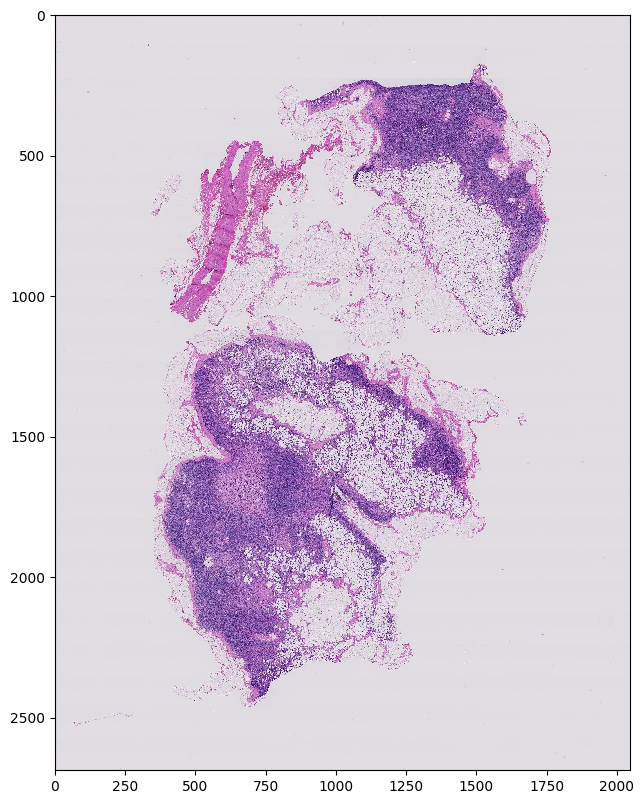

In [0]:
show_slide()

'mask'

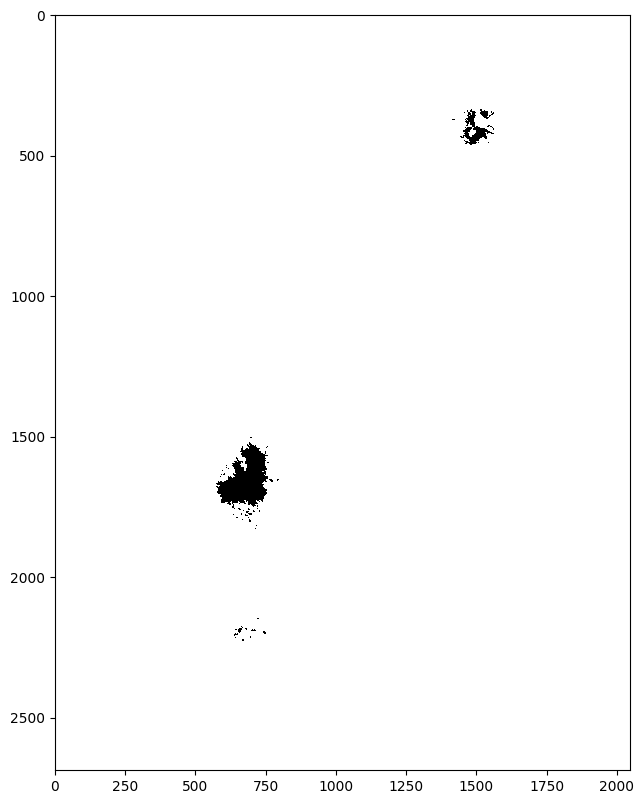

In [0]:
show_mask()

'overlay'

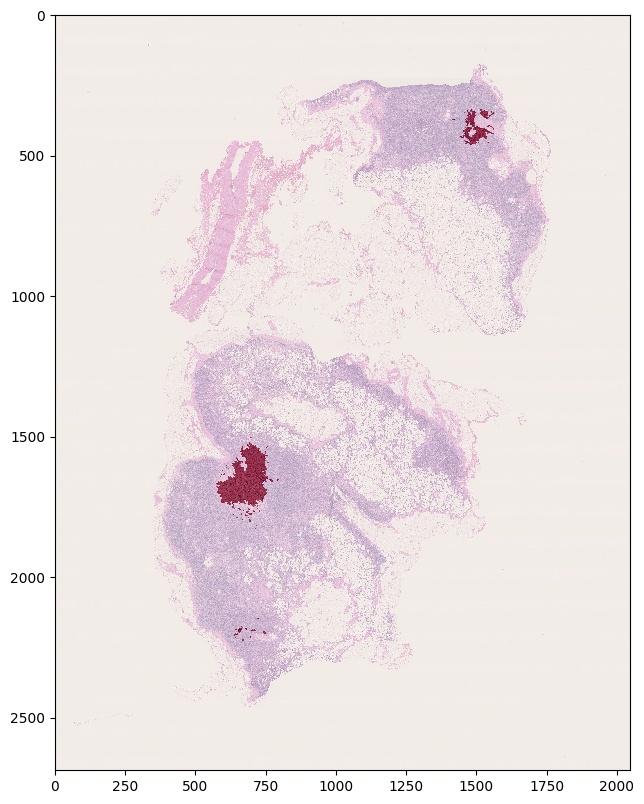

In [0]:
show_overlay(0.6)

In [0]:
df=pd.DataFrame(dat)
df

downsample factor image  level  max windows      x      y
0                  1   084      0        63054  65536  86016
1                  2   084      1        15763  32768  43008
2                  4   084      2         3940  16384  21504
3                  8   084      3          984   8192  10752
4                 16   084      4          245   4096   5376
5                 32   084      5           61   2048   2688
6                 64   084      6           14   1024   1344
7                128   084      7            3    512    672

In [0]:
df['x'][5]

2048

In [0]:
#Note "actual dim" represents the dimensions on the slide image
#actual_dim = float(df['x'][4])
#downsample = float(df['x'][5])
#correction = (downsample/actual_dim) * int(df['downsample factor'][5])
#correction

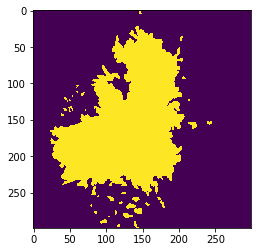

In [0]:
# Example: extract a (cancer) region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.

region = read_slide(tumor_mask, x=(550*32), y=(1500*32), level=5, width=299, height=299)[:,:,0]
plt.imshow(region)

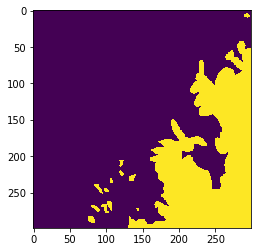

In [0]:
# Example: extract a (cancer) region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.

region = read_slide(tumor_mask, x=(550*32), y=(1500*32), level=4, width=299, height=299)[:,:,0]
plt.imshow(region)

In [0]:
# THIS IS THE PROPER ADJUSTMENT TO SHOW THAT 32 FILTER IS THE CORRECT ONE TO USE WITH MAX AND MIN ACCORDINGLY

#region = read_slide(tumor_mask, x=(1400*32), y=(4500*32), level=5, width=299, height=299)[:,:,0]
#plt.imshow(region)

In [0]:

tissue_pixels = list(find_tissue_pixels(slide_image))
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

1232170 tissue_pixels pixels (17.1 percent of the image)


In [0]:
mask_image.shape

(2688, 2048)

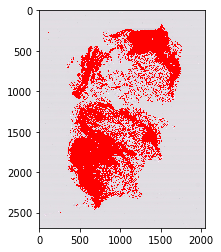

In [0]:
tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
tissue_regions.shape

(2688, 2048, 3)

## Data Preprocessing, Train/Test Split & Class Balance

Having created a list of image name references, we will now split the images randomly into train and test groups and generate the trainig dataset accordingly.

In [0]:
# hardcoding train/test split for replicability (actually used shuffling)
train_names = ['tumor_019', 'tumor_012', 'tumor_084', 'tumor_023', 'tumor_101', 'tumor_059', 'tumor_016', 'tumor_057', 'tumor_031', 'tumor_075', 'tumor_091', 'tumor_064', 'tumor_001', 'tumor_096', 'tumor_035', 'tumor_094', 'tumor_081', 'tumor_078']
test_names = ['tumor_005', 'tumor_002', 'tumor_110']

In [0]:
# randomly choosing three images from the original list to treat as a test set
#random.Random(9).shuffle(image_names) # CHANGED THIS FOR RERUN
#shuffled = image_names
#train_names = shuffled[3:]
#test_names = shuffled[:3]
print("Images chosen for testing:{}".format(test_names))
print("Images chosen for training:{}".format(train_names))

Images chosen for testing:['tumor_019', 'tumor_012', 'tumor_101']
Images chosen for training:['tumor_005', 'tumor_002', 'tumor_084', 'tumor_023', 'tumor_110', 'tumor_059', 'tumor_016', 'tumor_057', 'tumor_031', 'tumor_075', 'tumor_091', 'tumor_064', 'tumor_001', 'tumor_096', 'tumor_035', 'tumor_094', 'tumor_081', 'tumor_078']


In [0]:
# creating the training dataset for future model development (no data augmentation by default)
X_train, y_train = create_dataset_balanced(4, train_names, with_augmentation=False)

/content/gdrive/My Drive/tumor_data/tumor_019.tif
/content/gdrive/My Drive/tumor_data/tumor_019_mask.tif
opening slide & mask..
dims: 6112 13728
x steps: 19 y steps: 43
/content/gdrive/My Drive/tumor_data/tumor_012.tif
/content/gdrive/My Drive/tumor_data/tumor_012_mask.tif
opening slide & mask..
dims: 6112 13472
x steps: 19 y steps: 42
/content/gdrive/My Drive/tumor_data/tumor_084.tif
/content/gdrive/My Drive/tumor_data/tumor_084_mask.tif
opening slide & mask..
dims: 4096 5376
x steps: 13 y steps: 17
/content/gdrive/My Drive/tumor_data/tumor_023.tif
/content/gdrive/My Drive/tumor_data/tumor_023_mask.tif
opening slide & mask..
dims: 6112 13824
x steps: 19 y steps: 43
/content/gdrive/My Drive/tumor_data/tumor_101.tif
/content/gdrive/My Drive/tumor_data/tumor_101_mask.tif
opening slide & mask..
dims: 8704 4480
x steps: 27 y steps: 14
/content/gdrive/My Drive/tumor_data/tumor_059.tif
/content/gdrive/My Drive/tumor_data/tumor_059_mask.tif
opening slide & mask..
dims: 6080 13824
x steps: 19 

We will be working with 710 windows as our train dataset.
-
Train label class distribution is as follows:


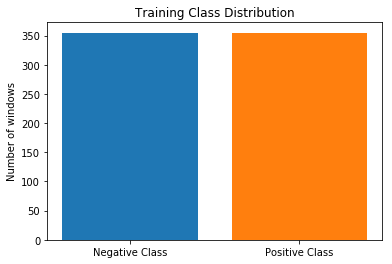

In [0]:
# checking the resulting shape and label distribution
print('We will be working with {} windows as our train dataset.'.format(len(X_train)))
print('-')
print('Train label class distribution is as follows:')
plt.bar(0, np.bincount(y_train)[0])
plt.bar(1, np.bincount(y_train)[1])
plt.xticks([0,1], labels = ('Negative Class', 'Positive Class'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution')
plt.show()

Note: below is an example of the unblanced distribution of classes at a higher zoom level

We will be working with 1817 windows as our train dataset.
-
Train label class distribution is as follows:


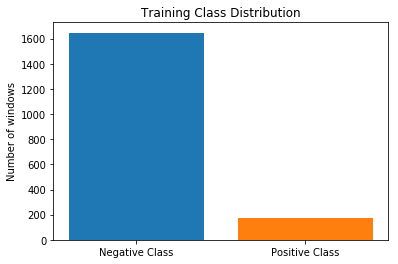

In [0]:
# checking the resulting shape and label distribution
#print('We will be working with {} windows as our train dataset.'.format(len(X_train)))
#print('-')
#print('Train label class distribution is as follows:')
#plt.bar(0, np.bincount(y_train)[0])
#plt.bar(1, np.bincount(y_train)[1])
#plt.xticks([0,1], labels = ('Negative Class', 'Positive Class'))
#plt.ylabel('Number of windows')
#plt.title('Training Class Distribution')
#plt.show()

Looking at the class distribution above, we can see that the data is heavily skewed towards negative class. Therefore, it is important to address this class imbalance before fitting any models. Otherwise, using the default accuracy metrics will be misleading.

In order to address the class imbalance, we have considered two approaches. 

1. Applying class weights inside the model. According to Keras documentation: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
2. Using the same sampling technique as the research paper: "Avoiding biases towards slides containing more patches (both normal and tumor) required careful sampling. First, we select “normal” or “tumor” with equal probability. Next, we select a slide that contains that class of patches uniformly at random, and sample patches from that slide."

For the data baseline preprocessing, we would simply be rescaling the training images by dividing by 255.

In [0]:
# rescaling the training dataset per standard practice
X_train = np.asarray(X_train) / 255.0 

In [0]:
X_train.shape

(602, 299, 299, 3)

In [0]:
sum(y_train)

301

**We no longer need to use class weight and under sampling since we implemented random sampling technique from the paper into our dataset creation function**

Showing the approaches worked with for visibility:

In [0]:
# calculating the balance ratio for the first approach
balance_ratio = np.bincount(y_train)[0]/np.bincount(y_train)[1]
#print(balance_ratio)
print('Balance ratio: {} '.format(np.round(balance_ratio, 3)))

Balance ratio: 1.0 


This legacy code, originally intended to set up a class penalty using a balance ratio, verifies that the improved sampling method achieves the intended goal

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print('Calculated class weights: 0: {}, 1: {}'.format(class_weights[0], class_weights[1]))

Calculated class weights: 0: 1.0, 1: 1.0


In [0]:
# working with random sampling through imbalance learn
X_train_os = X_train.reshape(X_train.shape[0], 299*299*3)
ros = RandomOverSampler(random_state=42, sampling_strategy={0:1620, 1:800})
X_train_os, y_train_os = ros.fit_resample(X_train_os, y_train)


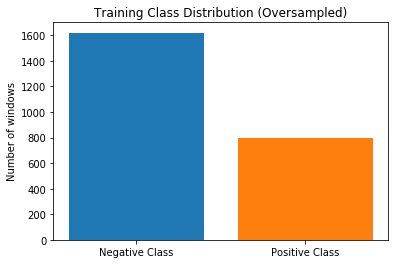

In [0]:
# new balanced dataset
plt.bar(0, np.bincount(y_train_os)[0])
plt.bar(1, np.bincount(y_train_os)[1])
plt.xticks([0,1], labels = ('Negative Class', 'Positive Class'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution (Oversampled)')
plt.show()

## Modeling & Inference

For modeling we decided to approach the problem by first working on a simple baseline model. Then, we have tried transfer learning -pretrained model on ImageNet to see if it would beat the baseline. Lastly, we have developed our own model guided by the research paper findings. Within the last model architecture, we applied data augmentation to attempt to increase model performance and forecastability.

### Baseline Model 

For the baseline model, we chose a simple DNN with some dropout added to avoid early overfitting.

In [0]:
X_train.shape

(710, 299, 299, 3)

Delete this first model

In [0]:

#from keras import models
#from keras import layers
#from keras import optimizers

@tf.function
model_baseline = models.Sequential()
model_baseline.add(layers.Flatten(input_shape=(299,299,3)))
#model.add(layers.Dense(128, activation=tf.nn.relu, input_dim = 299*299*3))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.5))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model_baseline.compile(optimizer=optimizers.Adam(lr=3e-5), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#note: learning rate chosen from best practice heuristic suggested here: http://karpathy.github.io/2019/04/25/recipe/

"Go-forward baseline model"

In [0]:
tf.keras.backend.clear_session()

In [0]:
model_baseline = models.Sequential()
model_baseline.add(layers.Flatten(input_shape=(299,299,3)))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.1))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.1))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.3))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Let us look at the model summary:

In [0]:
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 268203)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               137320448 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [0]:
BATCH = 40
train_steps = int(np.ceil(X_train.shape[0]*0.8 / BATCH))
val_steps = int(np.ceil(X_train.shape[0]*0.2 / BATCH))
history_baseline = model_baseline.fit(X_train, y_train, epochs = 10, validation_split=0.2, 
                                      batch_size = BATCH, shuffle = True)

Train on 568 samples, validate on 142 samples
Epoch 1/10
568/568 [==============================] - 2s 3ms/sample - loss: 1.0689 - accuracy: 0.5405 - val_loss: 0.4279 - val_accuracy: 0.8662
Epoch 2/10
568/568 [==============================] - 1s 3ms/sample - loss: 0.7559 - accuracy: 0.5915 - val_loss: 0.5123 - val_accuracy: 0.8873
Epoch 3/10
568/568 [==============================] - 1s 3ms/sample - loss: 0.6355 - accuracy: 0.6919 - val_loss: 0.4730 - val_accuracy: 0.8873
Epoch 4/10
568/568 [==============================] - 1s 3ms/sample - loss: 0.6421 - accuracy: 0.6620 - val_loss: 0.5325 - val_accuracy: 0.8662
Epoch 5/10
568/568 [==============================] - 1s 3ms/sample - loss: 0.6252 - accuracy: 0.6831 - val_loss: 0.4394 - val_accuracy: 0.8873
Epoch 6/10
568/568 [==============================] - 1s 3ms/sample - loss: 0.5876 - accuracy: 0.6937 - val_loss: 0.4490 - val_accuracy: 0.8803
Epoch 7/10
568/568 [==============================] - 1s 3ms/sample - loss: 0.5648 - accur

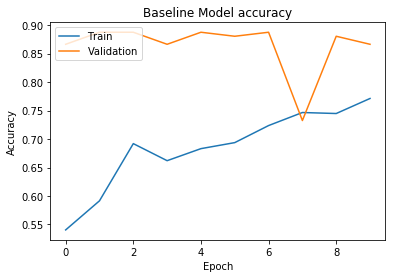

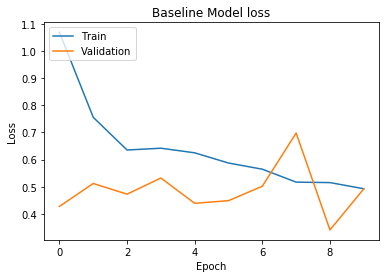

In [0]:
# Plot training & validation accuracy values
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Baseline Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('Baseline Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Interesting results - validation accuracy is greater than trainign accuracy over 10 epochs, although it appears to stall/hit a ceiling immediately.
* We ultimately demonstrate convergence with a dense neural network and do not expect high accuracy
* We also attempted to run this baseline at a higher zoom level but ran into memory issues and could not maintain a session. Accuracy was improved with the same architecture, implying we ultimately should pursue data augmentation and/or lower zoom levels

In [0]:
# creating test_dataset for fitting the model
X_test, y_test = create_dataset_test(level = 4, image_names = test_names)
X_test = X_test = np.asarray(X_test) / 255.0

In [0]:
y_pred_base = model_baseline.predict(X_test).ravel()
fpr_base, tpr_base, thresholds_base = roc_curve(y_test, y_pred_base)
auc_base = auc(fpr_base, tpr_base)

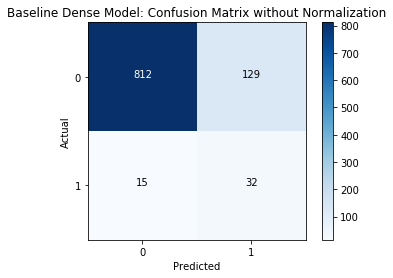

In [0]:
# outputting the confusion matrix
import itertools
rounded_pred_base = np.round(y_pred_base)
cf = confusion_matrix(y_test, rounded_pred_base)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Baseline Dense Model: Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred_base))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

Lots of false positives.. although, pleasingly, few(ish) false negatives. 
* Note that the class imbalance of the test images skews the ease with which we interpret the confusion matrix. 
* Ultimately, we correctly recall about 70% of the true positives

In [0]:
# generating ROC AUC score
roc_auc_baseline = roc_auc_score(y_test, rounded_pred_base)
print(roc_auc_baseline)

0.7718814298957651


In [0]:
# inspecting prediction mask for a single test image
predicted_mask, slide_image, mask_image = run_inference(4, test_names[2], model_baseline)

/content/gdrive/My Drive/tumor_data/tumor_101.tif
/content/gdrive/My Drive/tumor_data/tumor_101_mask.tif
opening slide & mask..
predicted mask shape: (4480, 8704)
dims: 8704 4480
x steps: 29 y steps: 14


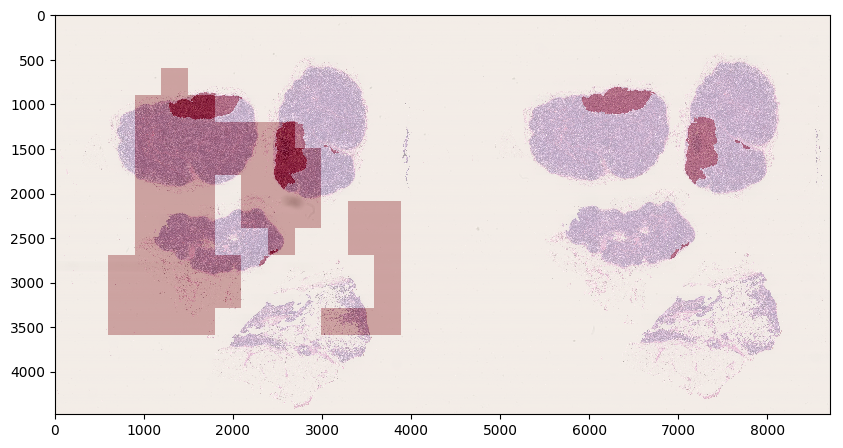

In [0]:
# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_019.tif
/content/gdrive/My Drive/tumor_data/tumor_019_mask.tif
opening slide & mask..
predicted mask shape: (13728, 6112)
dims: 6112 13728
x steps: 20 y steps: 45


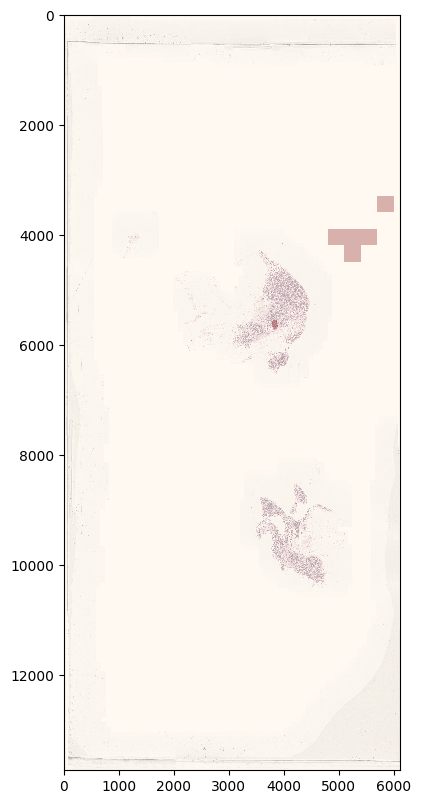

In [0]:
# another try with a different test image
predicted_mask3, slide_image3, mask_image3 = run_inference(4, test_names[0], model_baseline)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image3)
plt.imshow(mask_image3, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask3, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_012.tif
/content/gdrive/My Drive/tumor_data/tumor_012_mask.tif
opening slide & mask..
predicted mask shape: (6736, 3056)
dims: 3056 6736
x steps: 10 y steps: 22


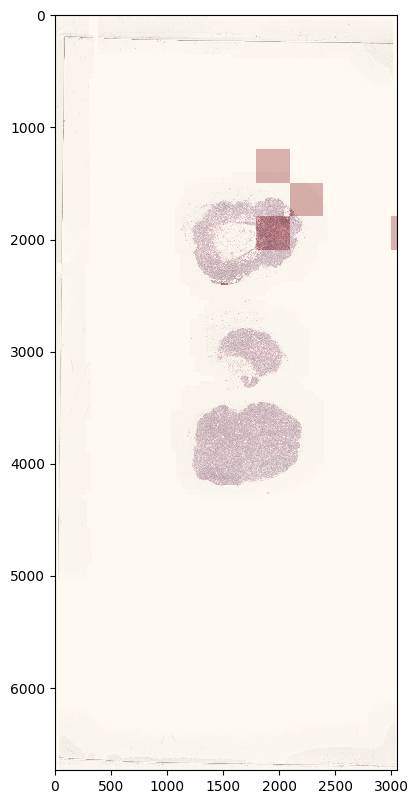

In [0]:
 # another try with a different test image
predicted_mask2, slide_image2, mask_image2 = run_inference(5, test_names[1], model_baseline)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image2)
plt.imshow(mask_image2, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask2, cmap='OrRd', alpha=0.3)
plt.show()

### CNN Model

In [0]:
tf.keras.backend.clear_session()

In [0]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

IMAGE_SIZE = 299

model_CNN = Sequential()
model_CNN.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model_CNN.add(Conv2D(first_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(MaxPooling2D(pool_size = pool_size))  #
model_CNN.add(Dropout(dropout_conv))

model_CNN.add(Conv2D(second_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(Conv2D(second_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(MaxPooling2D(pool_size = pool_size)) #
model_CNN.add(Dropout(dropout_conv))

model_CNN.add(Conv2D(third_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(Conv2D(third_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(MaxPooling2D(pool_size = pool_size)) #
model_CNN.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model_CNN.add(Flatten())
model_CNN.add(Dense(128, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(Dropout(dropout_dense))
model_CNN.add(Dense(1, activation = "sigmoid"))

# Compile the model
model_CNN.compile(Adam(), loss = "binary_crossentropy", metrics=["accuracy"])

In [0]:
BATCH = 32
history_CNN = model_CNN.fit(X_train, y_train, epochs = 15, validation_split=0.2, batch_size=BATCH,
                                        class_weight = class_weights, shuffle=True)

Train on 568 samples, validate on 142 samples
Epoch 1/15
568/568 [==============================] - 7s 12ms/sample - loss: 0.6534 - accuracy: 0.7887 - val_loss: 0.5959 - val_accuracy: 0.7676
Epoch 2/15
568/568 [==============================] - 6s 11ms/sample - loss: 0.4596 - accuracy: 0.8222 - val_loss: 0.6150 - val_accuracy: 0.7676
Epoch 3/15
568/568 [==============================] - 6s 11ms/sample - loss: 0.4244 - accuracy: 0.8257 - val_loss: 0.6441 - val_accuracy: 0.7676
Epoch 4/15
568/568 [==============================] - 6s 11ms/sample - loss: 0.4047 - accuracy: 0.8574 - val_loss: 0.6434 - val_accuracy: 0.7676
Epoch 5/15
568/568 [==============================] - 6s 11ms/sample - loss: 0.4491 - accuracy: 0.8204 - val_loss: 0.4465 - val_accuracy: 0.7676
Epoch 6/15
568/568 [==============================] - 6s 11ms/sample - loss: 0.3783 - accuracy: 0.8380 - val_loss: 0.4503 - val_accuracy: 0.7676
Epoch 7/15
568/568 [==============================] - 6s 11ms/sample - loss: 0.3641 

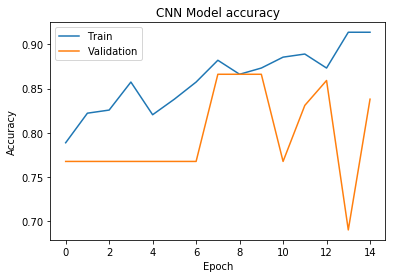

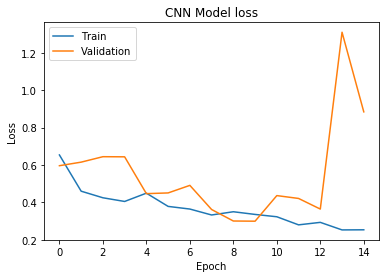

In [0]:
# Plot training & validation accuracy values
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# creating text_dataset for fitting the model
#X_test, y_test = create_dataset_test(level = 4, image_names = test_names)
#X_test = X_test = np.asarray(X_test) / 255.0

In [0]:
y_pred_cnn = model_CNN.predict(X_test).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

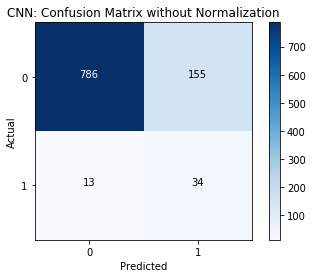

In [0]:
# outputting the confusion matrix
rounded_pred_cnn = np.round(y_pred_cnn)
cf = confusion_matrix(y_test, rounded_pred_cnn)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('CNN: Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred_cnn))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

We further reduce false negatives and improve recall, but it appears precision is slightly worse than baseline/dense model
* Note that a simple change to batch size from 32 to 64 completely changed these results and destroyed recall, while improving accuracy. Very odd. 

In [0]:
# generating ROC AUC score
roc_auc_cnn = roc_auc_score(y_test, rounded_pred_cnn)
print(roc_auc_cnn)

0.7793429353110091


Let's run inference using a CNN

/content/gdrive/My Drive/tumor_data/tumor_101.tif
/content/gdrive/My Drive/tumor_data/tumor_101_mask.tif
opening slide & mask..
predicted mask shape: (4480, 8704)
dims: 8704 4480
x steps: 29 y steps: 14


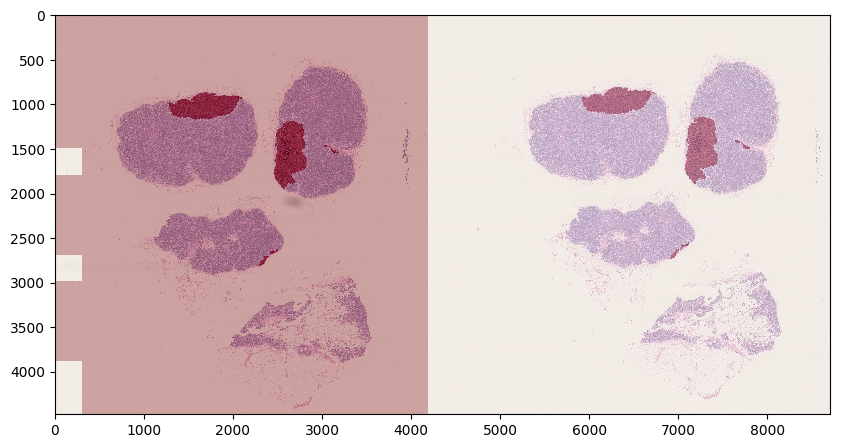

In [0]:
# another try with a different test image
predicted_mask_cnn, slide_image, mask_image = run_inference(4, test_names[2], model_CNN)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_cnn, cmap='OrRd', alpha=0.3)
plt.show()

Still odd that image 101 is double printing, with half the image being inferred as cancer
* Note that the lefthand piece validates what we see in the confusion matrix.. lots of false positives

### Transfer Learning Model

Having created the baseline, we wanted to also asses potential performance of a pre-trained model in classifying the dataset. We chose inception trained on ImageNet as our test model.

In [0]:
tf.keras.backend.clear_session()

In [0]:
# using inception
inception = InceptionV3(weights='imagenet',include_top=False, input_shape=(299, 299, 3))
inception.trainable = False

In [0]:
# setting up the model
model_inception = Sequential()
model_inception.add(inception)

model_inception.add(Flatten())
model_inception.add(Dense(128, activation=tf.nn.relu))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(1, activation='sigmoid'))

#dense model pulled from previousm placed on top of inception

model_inception.compile(optimizer='adam', 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history_inception = model_inception.fit(
      X_train, y_train,
      epochs=10,
      validation_split=0.2,
      verbose=1,
      shuffle=True,
      batch_size=40)

Train on 568 samples, validate on 142 samples
Epoch 1/10
568/568 [==============================] - 11s 19ms/sample - loss: 7.5349 - accuracy: 0.6109 - val_loss: 2.3089 - val_accuracy: 0.6901
Epoch 2/10
568/568 [==============================] - 4s 7ms/sample - loss: 1.2700 - accuracy: 0.8327 - val_loss: 0.5269 - val_accuracy: 0.7465
Epoch 3/10
568/568 [==============================] - 4s 7ms/sample - loss: 0.5400 - accuracy: 0.8169 - val_loss: 0.6388 - val_accuracy: 0.6690
Epoch 4/10
568/568 [==============================] - 4s 7ms/sample - loss: 0.4111 - accuracy: 0.7923 - val_loss: 0.8592 - val_accuracy: 0.5423
Epoch 5/10
568/568 [==============================] - 4s 7ms/sample - loss: 0.3805 - accuracy: 0.8486 - val_loss: 0.9433 - val_accuracy: 0.6268
Epoch 6/10
568/568 [==============================] - 4s 7ms/sample - loss: 0.3145 - accuracy: 0.8504 - val_loss: 0.4886 - val_accuracy: 0.7746
Epoch 7/10
568/568 [==============================] - 4s 7ms/sample - loss: 0.3090 - acc

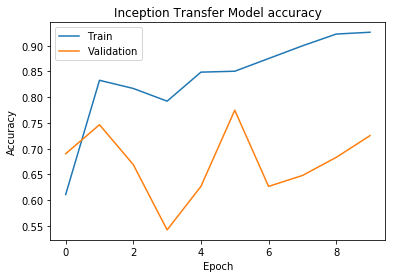

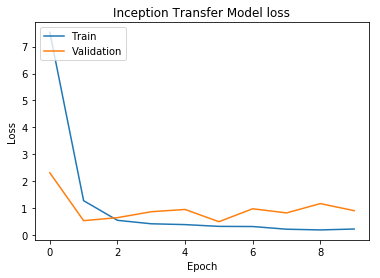

In [0]:
# Plot training & validation accuracy values
plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.title('Inception Transfer Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('Inception Transfer Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# creating text_dataset for fitting the model
#X_test, y_test = create_dataset_test(level = 4, image_names = test_names)
#X_test = np.asarray(X_test) / 255.0

In [0]:
y_pred_inc = model_inception.predict(X_test).ravel()
fpr_inc, tpr_inc, thresholds_inc = roc_curve(y_test, y_pred_inc)
auc_inc = auc(fpr_inc, tpr_inc)

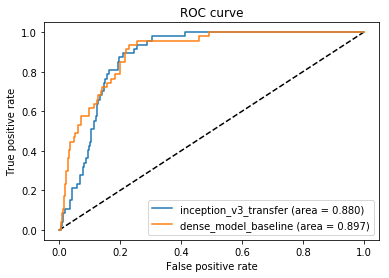

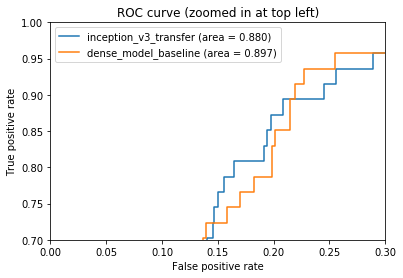

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inc, tpr_inc, label='inception_v3_transfer (area = {:.3f})'.format(auc_inc))
plt.plot(fpr_base, tpr_base, label='dense_model_baseline (area = {:.3f})'.format(auc_base))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inc, tpr_inc, label='inception_v3_transfer (area = {:.3f})'.format(auc_inc))
plt.plot(fpr_base, tpr_base, label='dense_model_baseline (area = {:.3f})'.format(auc_base))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

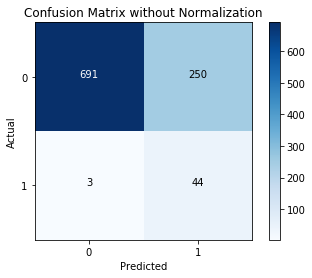

In [0]:
import itertools
# outputting the confusion matrix
rounded_pred = np.round(y_pred_inc)
cf = confusion_matrix(y_test, rounded_pred)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

Inception does a great job at improving recall! But again, precision is not great

In [0]:
# generating ROC AUC score
roc_auc_baseline = roc_auc_score(y_test, rounded_pred)
print(roc_auc_baseline)

0.8352476993691637


Trouble running inference using inception. Might be this second test image, image 012

In [0]:
# another try with a different test image
predicted_mask_tl, slide_image, mask_image = run_inference(4, test_names[1], model_inception)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_tl, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_012.tif
/content/gdrive/My Drive/tumor_data/tumor_012_mask.tif
opening slide & mask..


/content/gdrive/My Drive/tumor_data/tumor_078.tif
/content/gdrive/My Drive/tumor_data/tumor_078_mask.tif
opening slide & mask..
predicted mask shape: (6944, 5888)
dims: 5888 6944
x steps: 19y steps: 23


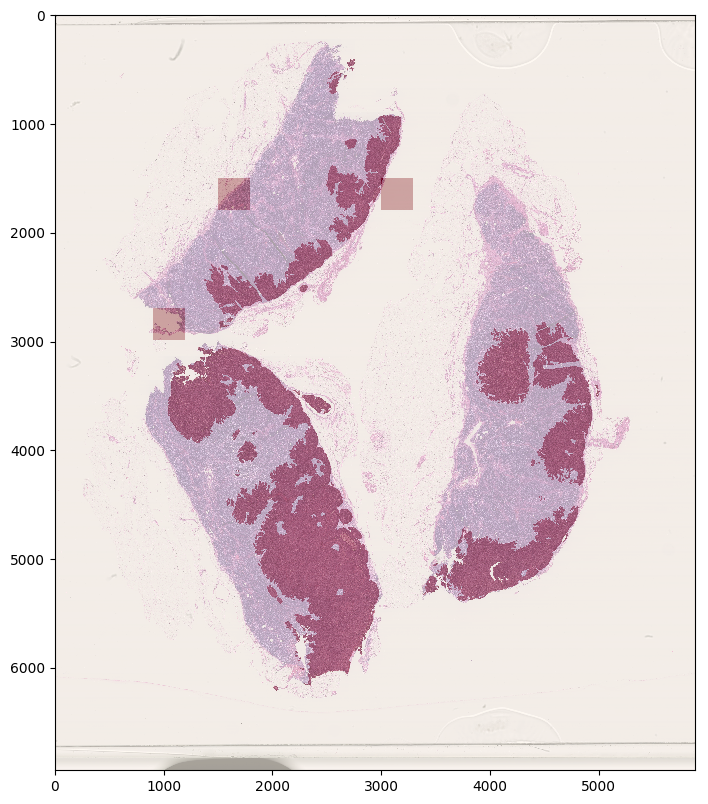

In [0]:
# another try with a different test image
predicted_mask_tl2, slide_image, mask_image = run_inference(4, test_names[2], model_inception)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_tl2, cmap='OrRd', alpha=0.3)
plt.show()

### Transfer Learning Model ( data augmentation)

Having created the baseline, we wanted to also asses potential performance of a pre-trained model in classifying the dataset. We chose inception trained on ImageNet as our test model.

In [0]:
tf.keras.backend.clear_session()

In [0]:
# using inception
inception = InceptionV3(weights='imagenet',include_top=False, input_shape=(299, 299, 3))
inception.trainable = False

In [0]:
# setting up the model
model_inception = Sequential()
model_inception.add(inception)

model_inception.add(Flatten())

model_inception.add(layers.Dense(512, activation=tf.nn.relu))
model_inception.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(512, activation=tf.nn.relu))
model_inception.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(128, activation=tf.nn.relu))
model_inception.add(layers.Dropout(0.3))
model_inception.add(layers.Dense(1, activation='sigmoid'))

'''model_inception.add(Dense(128, activation=tf.nn.relu))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(1, activation='sigmoid'))'''

#dense model pulled from previousm placed on top of inception

model_inception.compile(optimizer='adam', 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Note: validation accuracy not valid here, as it includes augmented data. Instead we validate on the test set

In [0]:
history_inception = model_inception.fit(
      X_train, y_train,
      epochs=10,
      validation_data=(X_test, y_test),
      verbose=1,
      shuffle=True,
      batch_size=40)

Train on 2130 samples, validate on 988 samples
Epoch 1/10
2130/2130 [==============================] - 25s 12ms/sample - loss: 3.0264 - accuracy: 0.6094 - val_loss: 0.4047 - val_accuracy: 0.7733
Epoch 2/10
2130/2130 [==============================] - 18s 8ms/sample - loss: 0.4748 - accuracy: 0.7864 - val_loss: 0.6156 - val_accuracy: 0.7439
Epoch 3/10
2130/2130 [==============================] - 18s 8ms/sample - loss: 0.3882 - accuracy: 0.8380 - val_loss: 0.4722 - val_accuracy: 0.7429
Epoch 4/10
2130/2130 [==============================] - 18s 8ms/sample - loss: 0.3362 - accuracy: 0.8615 - val_loss: 0.4698 - val_accuracy: 0.7642
Epoch 5/10
2130/2130 [==============================] - 18s 8ms/sample - loss: 0.2971 - accuracy: 0.8845 - val_loss: 0.7848 - val_accuracy: 0.7328
Epoch 6/10
2130/2130 [==============================] - 18s 8ms/sample - loss: 0.2464 - accuracy: 0.8981 - val_loss: 0.7694 - val_accuracy: 0.7368
Epoch 7/10
2130/2130 [==============================] - 18s 8ms/sample

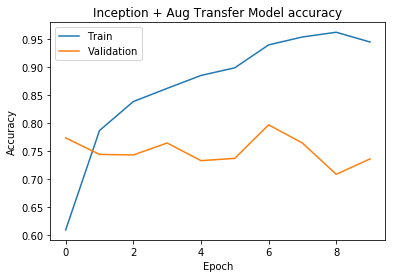

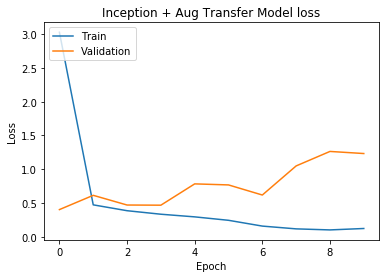

In [0]:
# Plot training & validation accuracy values
plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.title('Inception + Aug Transfer Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('Inception + Aug Transfer Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# creating text_dataset for fitting the model
#X_test, y_test = create_dataset_test(level = 4, image_names = test_names)
#X_test = np.asarray(X_test) / 255.0

In [0]:
y_pred_inc = model_inception.predict(X_test).ravel()
fpr_inc, tpr_inc, thresholds_inc = roc_curve(y_test, y_pred_inc)
auc_inc = auc(fpr_inc, tpr_inc)

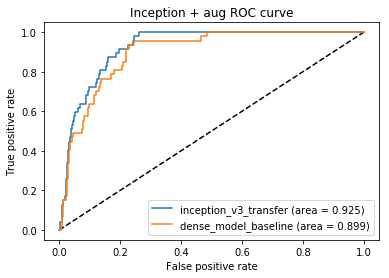

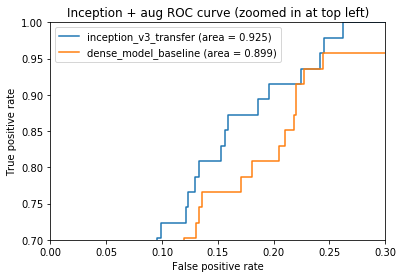

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inc, tpr_inc, label='inception_v3_transfer (area = {:.3f})'.format(auc_inc))
plt.plot(fpr_base, tpr_base, label='dense_model_baseline (area = {:.3f})'.format(auc_base))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Inception + aug ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inc, tpr_inc, label='inception_v3_transfer (area = {:.3f})'.format(auc_inc))
plt.plot(fpr_base, tpr_base, label='dense_model_baseline (area = {:.3f})'.format(auc_base))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Inception + aug ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

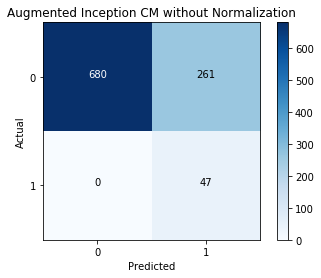

In [0]:
import itertools
# outputting the confusion matrix
rounded_pred = np.round(y_pred_inc)
cf = confusion_matrix(y_test, rounded_pred)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Augmented Inception CM without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

Inception does a great job at improving recall! But again, precision is not great

In [0]:
# generating ROC AUC score
roc_auc_baseline = roc_auc_score(y_test, rounded_pred)
print(roc_auc_baseline)

0.861317747077577


Trouble running inference using inception. Might be this second test image, image 012

In [0]:
# another try with a different test image
predicted_mask_tl, slide_image, mask_image = run_inference(4, test_names[1], model_inception)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_tl, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_012.tif
/content/gdrive/My Drive/tumor_data/tumor_012_mask.tif
opening slide & mask..
predicted mask shape: (13472, 6112)


/content/gdrive/My Drive/tumor_data/tumor_078.tif
/content/gdrive/My Drive/tumor_data/tumor_078_mask.tif
opening slide & mask..
predicted mask shape: (6944, 5888)
dims: 5888 6944
x steps: 19y steps: 23


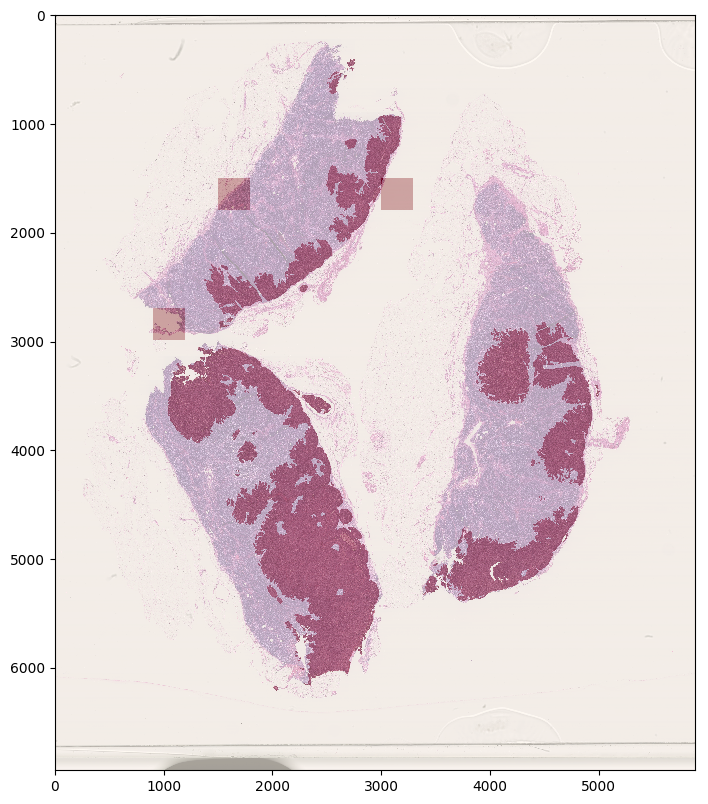

In [0]:
# another try with a different test image
predicted_mask_tl2, slide_image, mask_image = run_inference(4, test_names[2], model_inception)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_tl2, cmap='OrRd', alpha=0.3)
plt.show()

### Multi-zoom Model (baseline)

In [0]:
import keras.layers # import Input, Dense, Concatenate
import keras.models # import Model

In [0]:
train_names_sub = train_names[:12]

In [0]:
# creating a brand new dataset
# this takes a while, grab some coffee:)
# make sure the train and test names are generated in the section above
X_train2, y_train2 = create_dataset_v2_balanced([4,5], train_names_sub, with_augmentation=False)

/content/gdrive/My Drive/tumor_data/tumor_019.tif
/content/gdrive/My Drive/tumor_data/tumor_019_mask.tif
opening slide & mask..
dims: 6112 13728
/content/gdrive/My Drive/tumor_data/tumor_012.tif
/content/gdrive/My Drive/tumor_data/tumor_012_mask.tif
opening slide & mask..
dims: 6112 13472
/content/gdrive/My Drive/tumor_data/tumor_084.tif
/content/gdrive/My Drive/tumor_data/tumor_084_mask.tif
opening slide & mask..
dims: 4096 5376
/content/gdrive/My Drive/tumor_data/tumor_023.tif
/content/gdrive/My Drive/tumor_data/tumor_023_mask.tif
opening slide & mask..
dims: 6112 13824
/content/gdrive/My Drive/tumor_data/tumor_101.tif
/content/gdrive/My Drive/tumor_data/tumor_101_mask.tif
opening slide & mask..
dims: 8704 4480
/content/gdrive/My Drive/tumor_data/tumor_059.tif
/content/gdrive/My Drive/tumor_data/tumor_059_mask.tif
opening slide & mask..
dims: 6080 13824
/content/gdrive/My Drive/tumor_data/tumor_016.tif
/content/gdrive/My Drive/tumor_data/tumor_016_mask.tif
opening slide & mask..
dims

In [0]:
# preprocessing - already scaled in the create dataset
#X_train2 = np.asarray(X_train2) / 255.0 
#X_train2[0] = np.asarray(X_train2[0]) / 255.0
#X_train2[1] = np.asarray(X_train2[1]) / 255.0

In [0]:
# define two sets of inputs
input1 = tf.keras.layers.Input(shape=(299, 299, 3))
input2 = tf.keras.layers.Input(shape=(299, 299, 3))

tower1 = tf.keras.layers.Flatten()(input1)
tower1 = tf.keras.layers.Dense(128, activation="relu")(tower1)
tower1 = tf.keras.layers.Dense(128, activation="relu")(tower1)
tower1 = tf.keras.layers.Dropout(0.5)(tower1)
tower1 = tf.keras.models.Model(inputs=input1, outputs=tower1)

tower2 = tf.keras.layers.Flatten()(input2)
tower2 = tf.keras.layers.Dense(128, activation="relu")(tower2)
tower2 = tf.keras.layers.Dense(128, activation="relu")(tower2)
tower2 = tf.keras.layers.Dropout(0.5)(tower2)
tower2 = tf.keras.models.Model(inputs=input2, outputs=tower2)

 
# combine the output of the two branches
combined = tf.keras.layers.concatenate([tower1.output, tower2.output])
 
z = tf.keras.layers.Dense(64, activation="relu")(combined)
z = tf.keras.layers.Dense(1, activation="sigmoid")(z) # changed from softmax
 
# our model will accept the inputs of the two branches and
# then output a single value
model_towers = tf.keras.models.Model(inputs=[tower1.input, tower2.input], outputs=z)

model_towers.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy']) 

In [0]:
model_towers.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 268203)       0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 268203)       0           input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
EPOCHS = 15

history_towers = model_towers.fit(
      [X_train2[0], X_train2[1]], y_train2,
      epochs=EPOCHS,
      validation_split=0.1,
      verbose=1,
      shuffle=True,
      batch_size=32)

Train on 851 samples, validate on 95 samples
Epoch 1/15
851/851 [==============================] - 4s 5ms/sample - loss: 4.6435 - accuracy: 0.5159 - val_loss: 0.7069 - val_accuracy: 0.3895
Epoch 2/15
851/851 [==============================] - 3s 4ms/sample - loss: 2.2621 - accuracy: 0.5676 - val_loss: 0.4610 - val_accuracy: 0.8211
Epoch 3/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.9818 - accuracy: 0.6087 - val_loss: 0.3381 - val_accuracy: 0.8105
Epoch 4/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.5898 - accuracy: 0.7086 - val_loss: 0.4683 - val_accuracy: 0.8842
Epoch 5/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.5712 - accuracy: 0.7474 - val_loss: 0.5401 - val_accuracy: 0.8211
Epoch 6/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.5369 - accuracy: 0.7626 - val_loss: 0.3409 - val_accuracy: 0.8947
Epoch 7/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.5217 - accura

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
# Save entire model to a HDF5 file
model_towers.save('towers_model.h5')

In [0]:
model_file = drive.CreateFile({'title' : 'towers_model.h5'})                       
model_file.SetContentFile('towers_model.h5')
model_file.Upload()

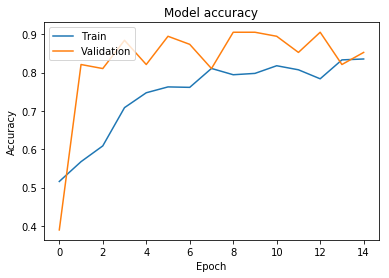

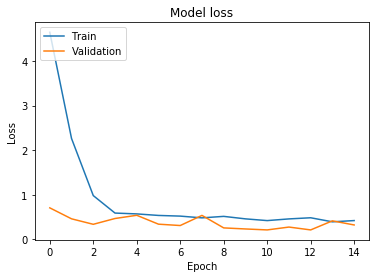

In [0]:
# Plot training & validation accuracy values
plt.plot(history_towers.history['accuracy'])
plt.plot(history_towers.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_towers.history['loss'])
plt.plot(history_towers.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# working with just one test image dur to GPU crashing
test_1 = []
test_1.append(test_names[2])
test_1.append(test_names[0])
test_1

['tumor_110', 'tumor_005']

In [0]:
# dropping training set to release memory
X_train2 = []
y_train2 = []

In [0]:
# creating test_dataset for fitting the model
X_test, y_test = create_dataset_test_v2([4,5], image_names = test_1)
#X_test = np.asarray(X_test) already scaled in the def

/content/gdrive/My Drive/tumor_data/tumor_110.tif
/content/gdrive/My Drive/tumor_data/tumor_110_mask.tif
opening slide & mask..
dims: 5888 4480
x steps: 43 y steps: 33
/content/gdrive/My Drive/tumor_data/tumor_005.tif
/content/gdrive/My Drive/tumor_data/tumor_005_mask.tif
opening slide & mask..
dims: 6112 13728
x steps: 45 y steps: 101


In [0]:
# if need to load the model
model_towers = tf.keras.models.load_model('towers_model.h5')

In [0]:
y_pred_towers = model_towers.predict(X_test) #.ravel()
#fpr_towers, tpr_towers, thresholds_towers = roc_curve(y_test, y_pred_towers)
#auc_inc = auc(fpr_towers, tpr_towers)

In [0]:
rounded_pred = np.round(y_pred_towers.ravel())

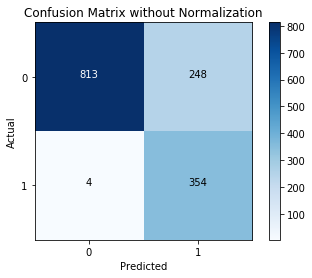

In [0]:
# outputting the confusion matrix
#rounded_pred = np.round(y_pred_towers)
cf = confusion_matrix(y_test, rounded_pred)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(2) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

In [0]:
# generating ROC AUC score
roc_auc_towers = roc_auc_score(y_test, rounded_pred)
print(roc_auc_towers)

0.877542531289655


/content/gdrive/My Drive/tumor_data/tumor_005.tif
/content/gdrive/My Drive/tumor_data/tumor_005_mask.tif
opening slide & mask..
predicted mask shape: (13728, 6112)
dims: 6112 13728
x steps: 47 y steps: 107


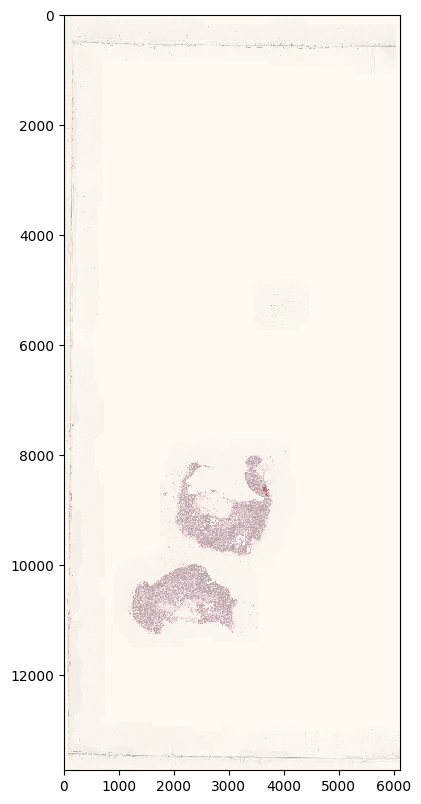

In [0]:
# another try with a different test image
predicted_mask_towers, slide_image, mask_image = run_inference_v2([4,5], test_names[0], model_towers)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_towers, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_002.tif
/content/gdrive/My Drive/tumor_data/tumor_002_mask.tif
opening slide & mask..
predicted mask shape: (13728, 6112)
dims: 6112 13728
x steps: 47 y steps: 107


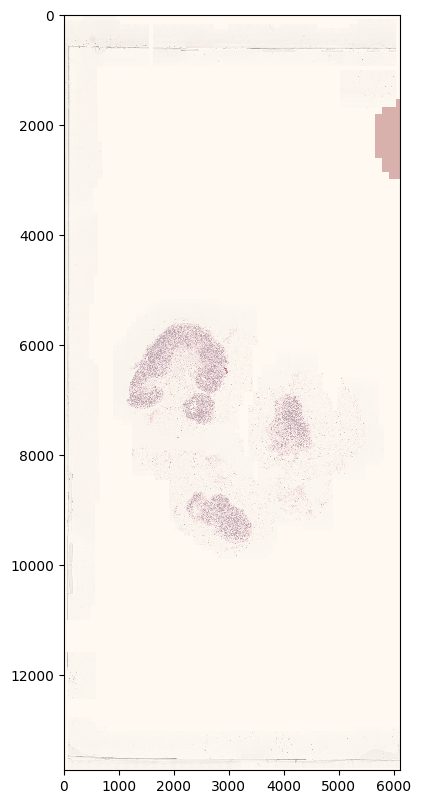

In [0]:
# another try with a different test image
predicted_mask_towers, slide_image, mask_image = run_inference_v2([4,5], test_names[1], model_towers)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_towers, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_110.tif
/content/gdrive/My Drive/tumor_data/tumor_110_mask.tif
opening slide & mask..
predicted mask shape: (4480, 5888)
dims: 5888 4480
x steps: 46 y steps: 35


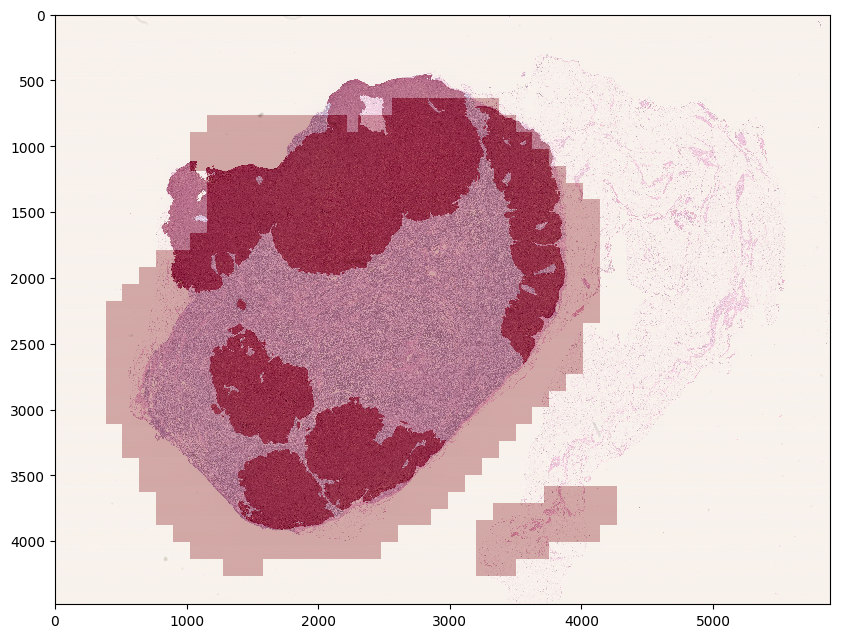

In [0]:
# another try with a different test image
predicted_mask_towers, slide_image, mask_image = run_inference_v2([4,5], test_names[2], model_towers)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_towers, cmap='OrRd', alpha=0.3)
plt.show()

### Multi-zoom model (with data augmentation)

In [0]:
import keras.layers # import Input, Dense, Concatenate
import keras.models # import Model

In [0]:
train_names_sub = train_names[:3]

In [0]:
# creating a brand new dataset
# this takes a while, grab some coffee:)
# make sure the train and test names are generated in the section above
sess = tf.InteractiveSession()
X_train2, y_train2 = create_dataset_v2_balanced_small([4,5], train_names_sub, with_augmentation=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


/content/gdrive/My Drive/tumor_data/tumor_019.tif
/content/gdrive/My Drive/tumor_data/tumor_019_mask.tif
opening slide & mask..
dims: 6112 13728


In [0]:
# preprocessing - already scaled in the create dataset
#X_train2 = np.asarray(X_train2) / 255.0 
#X_train2[0] = np.asarray(X_train2[0]) / 255.0
#X_train2[1] = np.asarray(X_train2[1]) / 255.0

In [0]:
# define two sets of inputs
input1 = tf.keras.layers.Input(shape=(299, 299, 3))
input2 = tf.keras.layers.Input(shape=(299, 299, 3))

tower1 = tf.keras.layers.Flatten()(input1)
tower1 = tf.keras.layers.Dense(128, activation="relu")(tower1)
tower1 = tf.keras.layers.Dense(128, activation="relu")(tower1)
tower1 = tf.keras.layers.Dropout(0.5)(tower1)
tower1 = tf.keras.models.Model(inputs=input1, outputs=tower1)

tower2 = tf.keras.layers.Flatten()(input2)
tower2 = tf.keras.layers.Dense(128, activation="relu")(tower2)
tower2 = tf.keras.layers.Dense(128, activation="relu")(tower2)
tower2 = tf.keras.layers.Dropout(0.5)(tower2)
tower2 = tf.keras.models.Model(inputs=input2, outputs=tower2)

 
# combine the output of the two branches
combined = tf.keras.layers.concatenate([tower1.output, tower2.output])
 
z = tf.keras.layers.Dense(64, activation="relu")(combined)
z = tf.keras.layers.Dense(1, activation="sigmoid")(z) # changed from softmax
 
# our model will accept the inputs of the two branches and
# then output a single value
model_towers = tf.keras.models.Model(inputs=[tower1.input, tower2.input], outputs=z)

model_towers.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy']) 

In [0]:
model_towers.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 268203)       0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 268203)       0           input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
EPOCHS = 10

history_towers = model_towers.fit(
      [X_train2[0], X_train2[1]], y_train2,
      epochs=EPOCHS,
      validation_split=0.1,
      verbose=1,
      shuffle=True,
      batch_size=32)

Train on 851 samples, validate on 95 samples
Epoch 1/15
851/851 [==============================] - 4s 5ms/sample - loss: 4.6435 - accuracy: 0.5159 - val_loss: 0.7069 - val_accuracy: 0.3895
Epoch 2/15
851/851 [==============================] - 3s 4ms/sample - loss: 2.2621 - accuracy: 0.5676 - val_loss: 0.4610 - val_accuracy: 0.8211
Epoch 3/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.9818 - accuracy: 0.6087 - val_loss: 0.3381 - val_accuracy: 0.8105
Epoch 4/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.5898 - accuracy: 0.7086 - val_loss: 0.4683 - val_accuracy: 0.8842
Epoch 5/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.5712 - accuracy: 0.7474 - val_loss: 0.5401 - val_accuracy: 0.8211
Epoch 6/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.5369 - accuracy: 0.7626 - val_loss: 0.3409 - val_accuracy: 0.8947
Epoch 7/15
851/851 [==============================] - 3s 4ms/sample - loss: 0.5217 - accura

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
# Save entire model to a HDF5 file
model_towers.save('towers_model.h5')

In [0]:
model_file = drive.CreateFile({'title' : 'towers_model.h5'})                       
model_file.SetContentFile('towers_model.h5')
model_file.Upload()

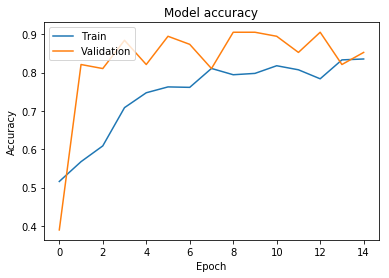

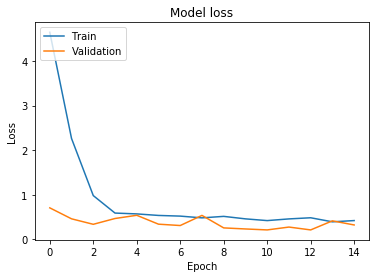

In [0]:
# Plot training & validation accuracy values
plt.plot(history_towers.history['accuracy'])
plt.plot(history_towers.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_towers.history['loss'])
plt.plot(history_towers.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# working with just one test image dur to GPU crashing
test_1 = []
test_1.append(test_names[2])
test_1.append(test_names[0])
test_1

['tumor_110', 'tumor_005']

In [0]:
# dropping training set to release memory
X_train2 = []
y_train2 = []

In [0]:
# creating test_dataset for fitting the model
X_test, y_test = create_dataset_test_v2([4,5], image_names = test_1)
#X_test = np.asarray(X_test) already scaled in the def

/content/gdrive/My Drive/tumor_data/tumor_110.tif
/content/gdrive/My Drive/tumor_data/tumor_110_mask.tif
opening slide & mask..
dims: 5888 4480
x steps: 43 y steps: 33
/content/gdrive/My Drive/tumor_data/tumor_005.tif
/content/gdrive/My Drive/tumor_data/tumor_005_mask.tif
opening slide & mask..
dims: 6112 13728
x steps: 45 y steps: 101


In [0]:
# if need to load the model
model_towers = tf.keras.models.load_model('towers_model.h5')

In [0]:
y_pred_towers = model_towers.predict(X_test) #.ravel()
#fpr_towers, tpr_towers, thresholds_towers = roc_curve(y_test, y_pred_towers)
#auc_inc = auc(fpr_towers, tpr_towers)

In [0]:
rounded_pred = np.round(y_pred_towers.ravel())

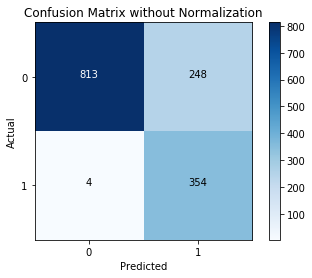

In [0]:
# outputting the confusion matrix
#rounded_pred = np.round(y_pred_towers)
cf = confusion_matrix(y_test, rounded_pred)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(2) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

In [0]:
# generating ROC AUC score
roc_auc_towers = roc_auc_score(y_test, rounded_pred)
print(roc_auc_towers)

0.877542531289655


/content/gdrive/My Drive/tumor_data/tumor_005.tif
/content/gdrive/My Drive/tumor_data/tumor_005_mask.tif
opening slide & mask..
predicted mask shape: (13728, 6112)
dims: 6112 13728
x steps: 47 y steps: 107


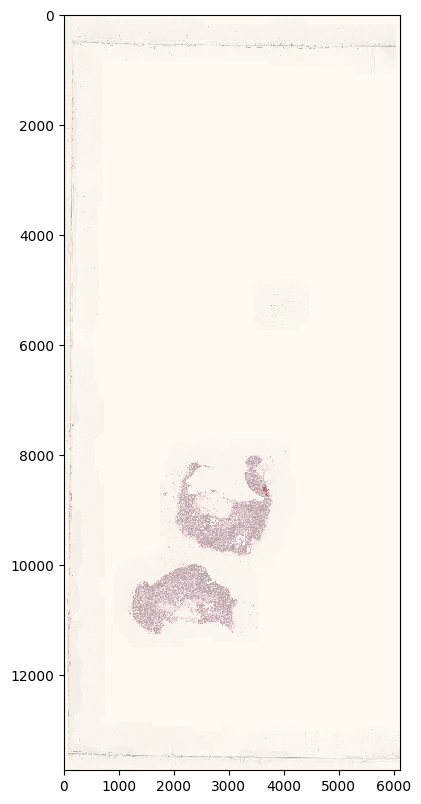

In [0]:
# another try with a different test image
predicted_mask_towers, slide_image, mask_image = run_inference_v2([4,5], test_names[0], model_towers)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_towers, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_002.tif
/content/gdrive/My Drive/tumor_data/tumor_002_mask.tif
opening slide & mask..
predicted mask shape: (13728, 6112)
dims: 6112 13728
x steps: 47 y steps: 107


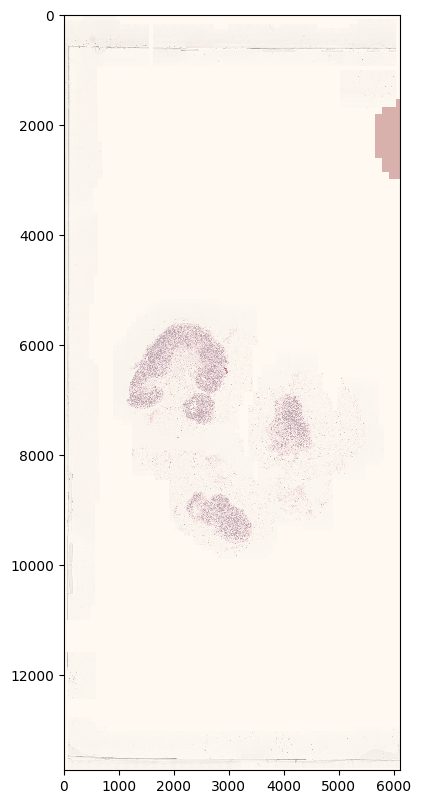

In [0]:
# another try with a different test image
predicted_mask_towers, slide_image, mask_image = run_inference_v2([4,5], test_names[1], model_towers)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_towers, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_110.tif
/content/gdrive/My Drive/tumor_data/tumor_110_mask.tif
opening slide & mask..
predicted mask shape: (4480, 5888)
dims: 5888 4480
x steps: 46 y steps: 35


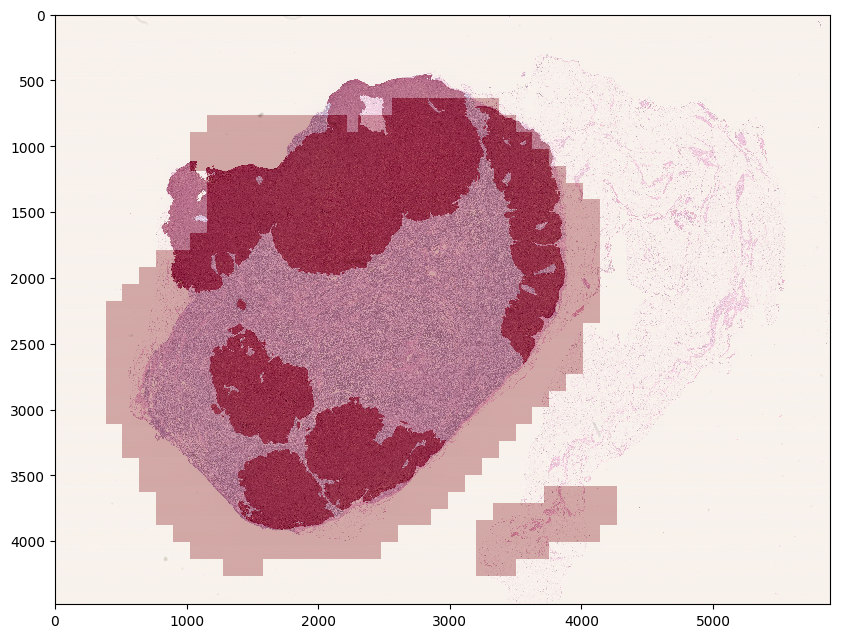

In [0]:
# another try with a different test image
predicted_mask_towers, slide_image, mask_image = run_inference_v2([4,5], test_names[2], model_towers)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_towers, cmap='OrRd', alpha=0.3)
plt.show()